## Лабораторна робота 1

Виконав Пушкар Максим, Статистика, Варіант 4

Завдання: 
1. Реалiзуйте алгоритм методу довiрчої областi. Допомiжну функцiю оберiть на власний розсуд.

2. Реалiзуйте алгоритм заснований на точцi Кошi.

3. Порiвняйте швидкiсть збiжностi в обох алгоритмах.

Функції для тестування:

1. $ f(x_1, x_2, x_3) = (x_1 + 2x_2 + x_1x_3)^2 + 2(x_3 + x_2^2)^2 + cx_1^4 $ для $c = 1, 10, 100$.

2. Згенеруйте випадкову матрицю $X$ розмiрностi $50 \times 2$ з даними, де кожен рядок має нормальний розподiл 
iз середнiми $(−1,3)$, дисперсiями$(1,2)$ та коварiацiєю рiвною $0$. Згеренуйте $50 \times 1$ вектор $Y$ за формулою 
$ Y_i = 1_{3X_i^{(1)} + X_i^{(2)} + \varepsilon_i > 0 } $.
Тут $\varepsilon_i \sim N(0,0.1)$. В якостi цiльової функцiї для оптимiзацiї оберiть функцiю максимальної правдоподiбностi або перехресну ентропiю в логiстичнiй регресiї. Чи пов’язанi цi функцiї?

### Setup

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

### Functions for optimization

#### Function 1

In [26]:
def f(x, c):
    return ( (x[0] + 2*x[1] + x[0]*x[2])**2 + 2*(x[2] + x[1]**2)**2 + c*x[0]**4 ).reshape(-1, 1)

Тут і надалі ми будемо використовувати .reshape у певнихх ситуаціях, коли може здаватись що він не потрібен (як тут, бо на виході має бути число), але насправді якщо в цю функцію передається вектор-стовпчик $x$, то на виході отримаємо рядок із одного числа, і щоб це не викликало проблем надалі (у мінімізації допоміжної функції) ми переганяємо його у формат стовпчика. Можна було зробити і інакше, але так воно більш consistant для інших функцій та методів що використовуються.

Нам знадобляться Градієнт та Гессіан цієї функції:

$$ \frac{\partial f}{\partial x_1} =  4cx_1^3 + 2(x_1 + 2x_2 + x_1x_3) (1 + x_3) $$
$$ \frac{\partial f}{\partial x_2} =  4(x_1 + 2x_2 + x_1x_3) + 8(x_3 + x_2^2)(x_2)$$
$$ \frac{\partial f}{\partial x_3} =  2(x_1 + 2x_2 + x_1x_3)x_1 + 4(x_3 + x_2^2)$$

In [27]:
def grad_f(x, c):
    x_1, x_2, x_3 = x
    return np.array([
        [4*c*x_1**3 + 2*(x_1 + 2*x_2 + x_1*x_3) * (1 + x_3)],
        [4*(x_1 + 2*x_2 + x_1*x_3) + 8*(x_3 + x_2**2)*(x_2)],
        [2*(x_1 + 2*x_2 + x_1*x_3)*x_1 + 4*(x_3 + x_2**2)]
    ]).reshape(-1, 1)

In [28]:
def hessian_f(x, c):
    x_1, x_2, x_3 = x
    return np.array([
        [2*(6*c*x_1**2 + (x_3 + 1)**2)     ,   4 * (1 + x_3)           ,     4*(x_1*x_3 + x_1 + x_2)],
        [4 * (1 + x_3)                     ,   8*(3*x_2**2 + x_3 + 1)  ,     4*(x_1 + 2*x_2)        ],
        [4*(x_1*x_3 + x_1 + x_2)           ,   4*(x_1 + 2*x_2)         ,     2*x_1*x_1 + 4          ]
    ]).reshape(3, 3)

Причина використання .reshape тут така сама як і в попередній функції.

#### Function 2

In [29]:
np.random.seed(seed=42)    # для відтворюваності результатів

mu = np.array([-1, 3])
sigma_squared = np.array([1, 2])

X = np.random.normal(mu, sigma_squared, (50, 2))
eps = np.random.normal(0, 0.1, (50, 1))

Y = (3*X[:,0] + X[:,1] + eps.T > 0).astype(int)
Y = Y.reshape((-1, 1))

Після того, як наші дані згенеровані, можна приступати до реалізації функції. Оберемо перехрестну ентропію у якості функції для мінімізації, яка для логістичної регресії є логарифмом від функції максимальної правдоподібності, лише що із мінусом, бо ми хочемо розглядати задачу мінімізації.

https://arunaddagatla.medium.com/maximum-likelihood-estimation-in-logistic-regression-f86ff1627b67

https://en.wikipedia.org/wiki/Logistic_regression#Many_explanatory_variables,_two_categories

$$ Loss(y, \hat{y}) = - \sum\limits_{k=1}^{50} \left( y_k \ln(\hat{y}_k) + (1-y_k) \ln(1 - \hat{y}_k) \right) $$

In [30]:
def Loss(Y, Y_hat):
    return - np.sum(Y * np.log(Y_hat) + (1 - Y)*np.log(1 - Y_hat))

In [31]:
def Loss_better(Y, Y_hat):
    mask = Y == 0

    ans = 0
    ans -= np.sum(np.log(1 - Y_hat[mask]))
    ans -= np.sum(np.log(Y_hat[~mask]))

    return ans

Тут реалізовано дві версії для $Loss$, одна із яких покладається на цю формулу в чистому вигляді, а інша враховує факт того що $y_k = 1$ або $0$, через що завжди один із двох доданків нульовий. Цей варіант кращий через те, що в певних випадках ми будемо отримувати помилку при обрахунку np.log, бо будемо рахувати логарифм чисел близьких до 0, причому це буде відбуватись в тому числі для тих випадків, коли обраховане число потім множиться на $0$. Розглядаючи ці випадки окремо ми уникаємо можливих помилок (що ми побачимо на практиці при оптимізації)

Нам потрібно означити наш елемент який буде претендувати на розв'язок задачі мінімізації:

$$ \hat{Y} = \sigma(W \cdot X) = \sigma(w_1X^{(1)} + w_2X^{(2)})$$

де

$$ \sigma(x) = \frac{1}{1 + e^{-x}} \ \ \ \  ; \ \ \ \ \sigma'(x) = \sigma(x) (1 - \sigma(x))$$ 

In [32]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))


def target(W, X, Y):
    w1, w2 = W

    Y_hat = sigmoid(w1 * X[:, 0] + w2 * X[:, 1])

    return Loss(Y, Y_hat.reshape([-1, 1]))


def target_better(W, X, Y):
    w1, w2 = W

    Y_hat = sigmoid(w1 * X[:, 0] + w2 * X[:, 1])

    return Loss_better(Y, Y_hat.reshape([-1, 1]))

In [33]:
target(np.array([3, 1]), X, Y) - target_better(np.array([3, 1]), X, Y)


3.552713678800501e-15

Порахуємо градієнт від $Target(w)$:

$$ Target = Loss(Y, \hat{Y}) = Loss(Y, \sigma(w_1X^1 + w_2X^2)) $$ 

$$ \frac{\partial Target}{\partial w_1} = \frac{\partial Target}{\partial \hat{Y}} \frac{\partial \hat{Y}}{\partial w_1}$$

$$ \frac{\partial Target}{\partial w_1} = -\sum\limits_{k=1}^{50}\left(\frac{y_k}{\hat{y}_k} - \frac{1 - y_k}{1 - \hat{y}_k}\right) \times \sigma'(w_1x_k^1 + w_2x_k^2) x_k^1 = 
-\sum\limits_{k=1}^{50} x_k^1 \sigma(w_1x_k^1 + w_2x_k^2) (1 - \sigma(w_1x_k^1 + w_2x_k^2)) \left(\frac{y_k}{\hat{y}_k} - \frac{1 - y_k}{1 - \hat{y}_k}\right) =$$
$$ = -\sum\limits_{k=1}^{50} x_k^1 \hat{y}_k (1 - \hat{y}_k) \left(\frac{y_k}{\hat{y}_k} - \frac{1 - y_k}{1 - \hat{y}_k}\right) = -\sum\limits_{k=1}^{50} x_k^1  \left(y_k (1 - \hat{y}_k) - (1 - y_k)\hat{y}_k\right)$$

$$ \frac{\partial Target}{\partial w_2} = -\sum\limits_{k=1}^{50} x_k^2  \left(y_k (1 - \hat{y}_k) - (1 - y_k)\hat{y}_k\right) $$

In [34]:
def grad_target(W, X, Y):
    w1, w2 = W

    Y_hat = sigmoid(w1 * X[:, 0] + w2 * X[:, 1])
    Y_hat = Y_hat.reshape([-1, 1])

    dw1 = -np.sum( X[:, 0].reshape([-1, 1]) * (Y * (1 - Y_hat) - (1 - Y) * Y_hat))
    dw2 = -np.sum( X[:, 1].reshape([-1, 1]) * (Y * (1 - Y_hat) - (1 - Y) * Y_hat))

    return np.array([dw1, dw2]).reshape([-1, 1])

Перевіримо емпірично, що формули вище правильні. Для цього порахуємо похідну вручну наближено, та з використанням функції вище:

In [35]:
eps = 0.00000001
W_0 = np.array([[1], [2]])

ans_1 = (target(W_0 + np.array([[eps], [0]]), X, Y) - target(W_0, X, Y))/eps
ans_2 = (target(W_0 + np.array([[0], [eps]]), X, Y) - target(W_0, X, Y))/eps

print(np.array([[ans_1], [ans_2]]) - grad_target(W_0, X, Y))

[[4.38472274e-06]
 [6.24150552e-06]]


Порахуємо Гессіан:

$$ \frac{\partial Target}{\partial w_1} = -\sum\limits_{k=1}^{50} x_k^1  \left(y_k (1 - \hat{y}_k) - (1 - y_k)\hat{y}_k\right) $$

$$ \frac{\partial^2 Target}{(\partial w_1)^2} = \frac{\partial Target}{\partial w_1 \partial \hat{y}_k}  \frac{\partial \hat{y}_k}{\partial w_1}$$

$$ \frac{\partial^2 Target}{(\partial w_1)^2} = -\sum\limits_{k=1}^{50} x_k^1 \left( - y_k - (1 - y_k) \right) x_k^1 \hat{y}_k (1 - \hat{y}_k) = 
\sum\limits_{k=1}^{50} (x_k^1)^2 \hat{y}_k (1 - \hat{y}_k)  $$

$$ \frac{\partial^2 Target}{(\partial w_2)^2} = \sum\limits_{k=1}^{50} (x_k^2)^2 \hat{y}_k (1 - \hat{y}_k)  $$

$$ \frac{\partial^2 Target}{\partial w_1 \partial w_2} = \sum\limits_{k=1}^{50} x_k^1 x_k^2 \hat{y}_k (1 - \hat{y}_k)  $$

In [36]:
def hessian_target(W, X, Y):
    w1, w2 = W

    X_1 = X[:, 0].reshape([-1, 1])
    X_2 = X[:, 1].reshape([-1, 1])

    Y_hat = sigmoid(w1 * X[:, 0] + w2 * X[:, 1])
    Y_hat = Y_hat.reshape([-1, 1])
    
    Target_dw_1_dw_1 = np.sum( X_1 * X_1 * Y_hat * (1 - Y_hat) )
    Target_dw_2_dw_2 = np.sum( X_2 * X_2 * Y_hat * (1 - Y_hat) )
    Target_dw_1_dw_2 = np.sum( X_1 * X_2 * Y_hat * (1 - Y_hat) )
    
    return np.array([
        [Target_dw_1_dw_1, Target_dw_1_dw_2],
        [Target_dw_1_dw_2, Target_dw_2_dw_2]
    ])

Перевіримо емпірично, що все пораховано правильно:

In [37]:
eps = 0.0000001
W_0 = np.array([[1], [2]])

ans_1 = (grad_target(W_0 + np.array([[eps], [0]]), X, Y) - grad_target(W_0, X, Y))/eps
ans_2 = (grad_target(W_0 + np.array([[0], [eps]]), X, Y) - grad_target(W_0, X, Y))/eps

emp_hessian = np.array([ans_1, ans_2]).reshape((2,2))

print(emp_hessian - hessian_target(W_0, X, Y))

[[ 2.88759630e-07 -1.05537620e-07]
 [ 2.49733748e-07 -3.51359609e-07]]


### Метод довірчої області

Почнемо із того, що навчимося мінімізовувати квадратичну функцію на області $ \| p \|  \leq \Delta $. 

$$ m_k(p) = f_k + p^T \nabla f_k + \frac12 p^T \nabla^2 f_k p $$

Всередині наступного класу ми реалізуємо знаходження справжнього мінімуму (за допомогою бібліотеки cvxpy для роботи із оптиміхацією опуклих функцій із опуклими обмеженнями). Також всередині реалізуємо знаходження точки Коші. 

Документація cvxpy: https://www.cvxpy.org/tutorial/dcp/index.html

Приклад на якому заснований код нижче: https://www.cvxpy.org/examples/basic/socp.html

In [40]:
class Quadratic_func:
    def __init__(self, f_k, grad_f_k, hessian_f_k, constrain):
        self.c = f_k
        self.b = grad_f_k
        self.a = hessian_f_k
        self.delta = constrain

    def as_func(self):
        def result(p):    # assumed to be vector column
            # take [0, 0] to avoid results [[12]], that appear due to nature of matrix multiplication
            return (self.c + p.T @ self.b + 1/2 * p.T @ self.a @ p)[0, 0]    
        return result    # returns an entire function
    
    def find_min(self):
        try:
            n = self.a.shape[0]
            p = cp.Variable(n)

            target = self.c + p.T @ self.b + p.T @ (self.a/2) @ p

            prob = cp.Problem(cp.Minimize(target), [cp.SOC(self.delta, p)])
            prob.solve()

            return prob.value, p.value    # return new optimal value, then the optimal parameters
        
        except cp.DCPError:    # In case if hessian_f_k is not positive-semidefinite, the convex minimization in cvxpy fails.
            print("Hessian is not positive-semidefinite. Optimization cannot continue further.")

    def find_Cauchy_point(self):
        # this is the realization of the formula from the lecture notes.

        cond = (self.b.T @ self.a @ self.b)[0,0] <= 0
        direction_min = ( np.linalg.norm(self.b)**3 / (self.delta * self.b.T @ self.a @ self.b) )[0,0]

        theta = 1 if cond else np.min([1, np.min([1, direction_min])])
        p = - theta * self.delta / np.linalg.norm(self.b) * self.b
        return self.as_func()(p), p.flatten()

Проведемо тест, як працює наша оптимізація:

In [41]:
q = Quadratic_func(1, np.array([[1], [1]]), np.array([[2, 0], [0, 1]]), 1)
print(q.find_min())
print(q.find_Cauchy_point())

(0.25778233434979536, array([-0.46900312, -0.88319651]))
(0.33333333333333326, array([-0.66666667, -0.66666667]))


In [42]:
q = Quadratic_func(1, np.array([[1], [1], [1]]), np.array([[2, 0, 0], [0, 1, 0], [0, 0, 1]]), 1)
print(q.find_min())
print(q.find_Cauchy_point())

(-0.11620045893720343, array([-0.39392106, -0.64993315, -0.64993315]))
(-0.06538414090221079, array([-0.57735027, -0.57735027, -0.57735027]))


Тепер перейдемо до реалізації алгоритму як такого. Вся схема повністю взята із матеріалів лекцій із збереженням позначень. У функцію передаємо:

1. f - функція яку оптимізуємо

2. grad_f - функція градієнта

3. hessian_f - функція гесіана 

4. x_0 - початкова точка

5. delta_0 - початковий радіус області

6. delta_max - максимальний радіус області

7. eta - параметр $\eta$ потрібний для визначення чи відбується зміна $x$

8. iter_max - Клькість ітерацій, за яку ми спостерігаємо за поведінкою алгоритму

9. type - Метод яким вирізуємо допоміжну задачу. Може бути "Full" або "Cauchy"

10. kwargs - додаткові фіксовані аргументи що передаються у функції f, grad_f, hessian_f

Всі додаткові деталі прописані всередині коду.

In [43]:
def Trust_area_method(f, grad_f, hessian_f, x_0, delta_0, delta_max, eta, iter_max, type="Full", **kwargs):
    # type is "Full" or "Cauchy"

    # test if parameters inserted satisfy the requirements
    assert delta_0 > 0 and delta_0 < delta_max
    assert eta >= 0 and eta < 1/4

    # store the data for each iteration that we would need later
    p_list = []
    rho_list = []
    delta_list = [delta_0]
    x_list = [x_0]

    x = x_0.copy()
    delta = delta_0

    for _ in range(iter_max):
        m = Quadratic_func(f(x, **kwargs), grad_f(x, **kwargs), hessian_f(x, **kwargs), delta)

        if type == "Full":
            try:
                min_val, p = m.find_min()
            except TypeError:    # raises if the .find_min() returns None in case if Hessian is not positive-semidefinite.
                return x, [p_list, rho_list, delta_list, x_list]
        elif type == "Cauchy":
            min_val, p = m.find_Cauchy_point()
        
        p = p.reshape([-1, 1])
        p_list.append(p.copy())    # store a copy because p is a list and it is mutable

        rho = (m.c - f(x + p, **kwargs))/(m.c - min_val)    # m.c = m(0) = f(x) ; min_val = m(p)
        rho_list.append(rho)

        if rho < 1/4:
            delta = 1/4 * delta
        elif rho > 3/4 and np.allclose(np.linalg.norm(p), delta, atol=1e-08):
            delta = np.min([2 * delta, delta_max])
        
        delta_list.append(delta)

        if rho > eta:
            x += p

        x_list.append(x.copy())    # store a copy because p is a list and it is mutable

    return x, [p_list, rho_list, delta_list, x_list]

Наступна функція потрібна для візуалізації наших результатів. Вона будує 4 (або за потреби 5) графіків, а саме:

1. Залежність $\| x_k - x_{ans} \|$ від $k$ (номер ітерації)

2. $\Delta_k$ та $\| p_k \|$ від $k$

3. $f(x_k) - f(x_{ans})$ від $k$

4. $\| \nabla f(x_k) \|$ від $k$

5. (Optional) $\rho_k$ від $k$

$x_{ans}$ може або передаватись явно у функцію, або може вважатись останнім значенням до якого дійшов алгоритм.

In [65]:
def plot_graphs(dynamic, f, grad_f, x_ans=None, log_scale=False, show_rho=False, one_line=True, **kwargs):
    p_list, rho_list, delta_list, x_list = dynamic

    if x_ans is None:
        x_ans = x_list[-1]

    x_norms = [np.linalg.norm(x - x_ans) for x in x_list]
    p_norms = [np.linalg.norm(p) for p in p_list]
    rho_norms = np.array(rho_list).flatten()
    delta_list = delta_list.copy()

    f_values = [np.sum([f(x, **kwargs)]) - np.sum([f(x_ans, **kwargs)])  for x in x_list]
    grad_norm = [np.linalg.norm(grad_f(x, **kwargs)) for x in x_list]

    if show_rho and not one_line:
        plt.rcParams.update({'font.size': 22})
        
        fig, ax = plt.subplots(2, 3, figsize=(15, 10))

        ax_norm_x = ax[0, 0]
        ax_increment = ax[0, 1]
        ax_f = ax[1, 0]
        ax_grad = ax[1, 1]

    elif not show_rho and not one_line:
        plt.rcParams.update({'font.size': 22})

        fig, ax = plt.subplots(2, 2, figsize=(12, 12))

        ax_norm_x = ax[0, 0]
        ax_increment = ax[0, 1]
        ax_f = ax[1, 0]
        ax_grad = ax[1, 1]

    else:
        plt.rcParams.update({'font.size': 20})
        
        show_rho = False

        fig, ax = plt.subplots(1, 4, figsize=(30, 7))

        ax_norm_x = ax[0]
        ax_increment = ax[1]
        ax_f = ax[2]
        ax_grad = ax[3]


    ax_norm_x.plot(x_norms)
    ax_norm_x.set_title("Argument convergence")
    ax_norm_x.set_xlabel(r"$k$")
    ax_norm_x.legend([r"$\|\| x_k - x_{ans} \|\|$"])
    # ax_norm_x.set_ylabel(r"$\|\| x_k - x_{ans} \|\|$")


    ax_increment.plot(delta_list, c="blue")
    ax_increment.plot(p_norms, c="red")
    ax_increment.set_xlabel(r"$k$")
    ax_increment.set_title("Attempted increment")
    ax_increment.legend([r"$\Delta_k$", r"$\|\| p_k \|\|$"])


    ax_f.plot(f_values)
    ax_f.set_xlabel(r"$k$")
    # ax_f.set_ylabel(r"$f(x_k) - f(x_{ans})$")
    ax_f.legend([r"$f(x_k) - f(x_{ans})$"])
    ax_f.set_title("Function values")


    ax_grad.plot(grad_norm)
    ax_grad.set_xlabel(r"$k$")
    ax_grad.legend([r"$\|\| \nabla f(x_k) \|\| $"])
    # ax_grad.set_ylabel(r"$\|\| \nabla f(x_k) \|\| $")
    ax_grad.set_title("Gradient norm")


    if show_rho:
        ax_rho = ax[0, 2]
        ax_rho.set_title(r"Internal parameter $\rho$")
        ax_rho.plot(rho_norms)
        ax_rho.set_xlabel(r"$k$")
        ax_rho.set_ylabel(r"$\rho_k$")


    # it is impossible to see what happens on large iterations, therefore we will use 
    # logarithmic scale for most of them. 
    if log_scale:    
        ax_grad.set_yscale("log")
        ax_norm_x.set_yscale("log")

        ax_f.set_yscale("log")
        ax_increment.set_yscale("log")


    plt.show()

### Tests

#### Func_1 test

Для справедливості порівняння роботи обох алгоритмів запускаємо їх з однієї початвої умови для обох алгоритмів за всіх значень $c$.

In [66]:
x_0 = 0.5*np.array([1.0, 1.0, 1.0]).reshape([-1, 1])

In [67]:
c_list = [1, 10, 100]

For c=1 achieved value is 1.324410489940526e-19 in the point [ 1.90768055e-05 -9.53840278e-06 -9.09773558e-11]


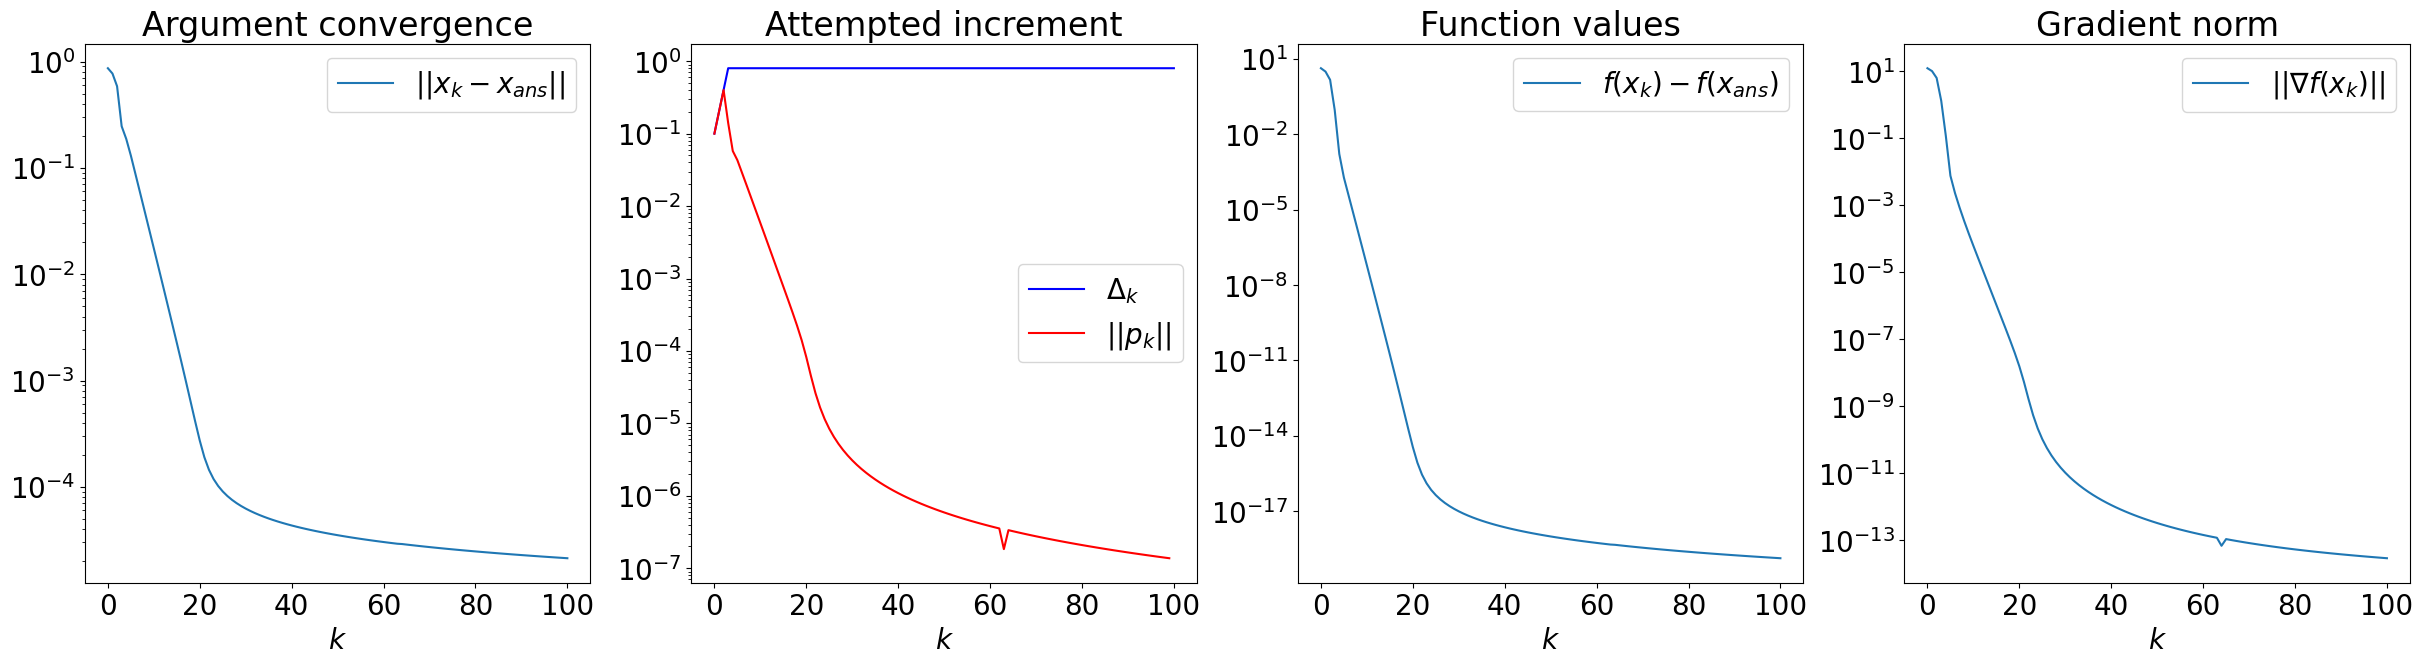

###############################################################################################################################
For c=10 achieved value is 1.3840115760350553e-20 in the point [ 6.09936932e-06 -3.04968466e-06 -9.30017349e-12]


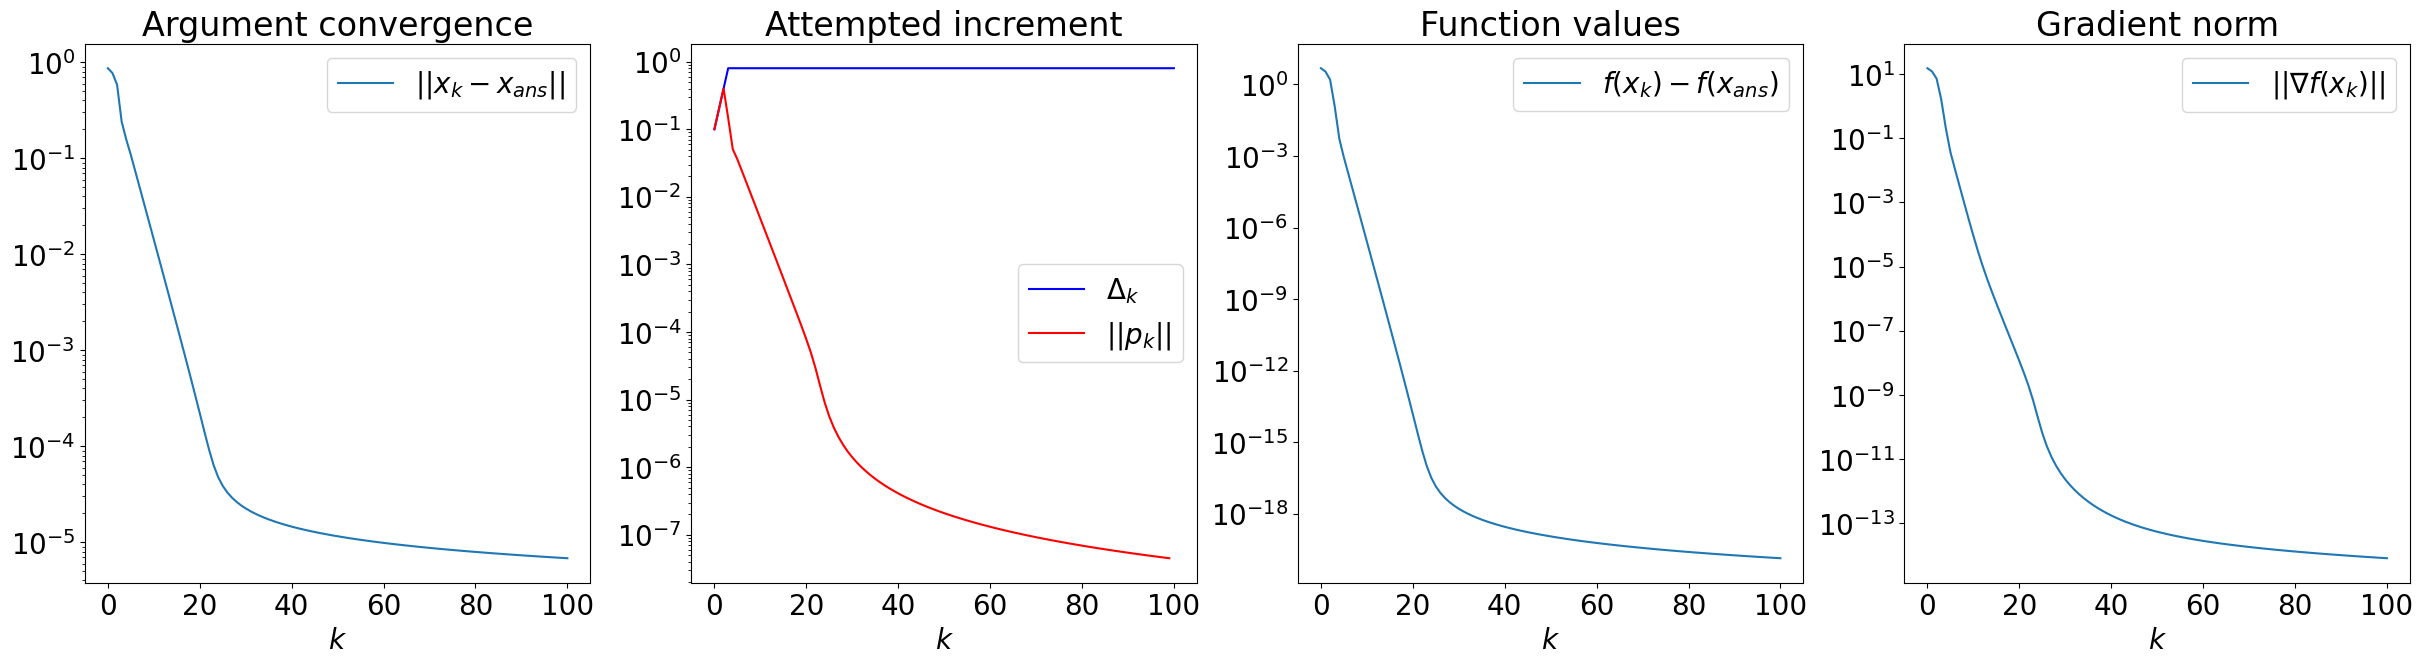

###############################################################################################################################
For c=100 achieved value is 1.4758264640839105e-21 in the point [ 1.96001242e-06 -9.80006210e-07 -9.60367775e-13]


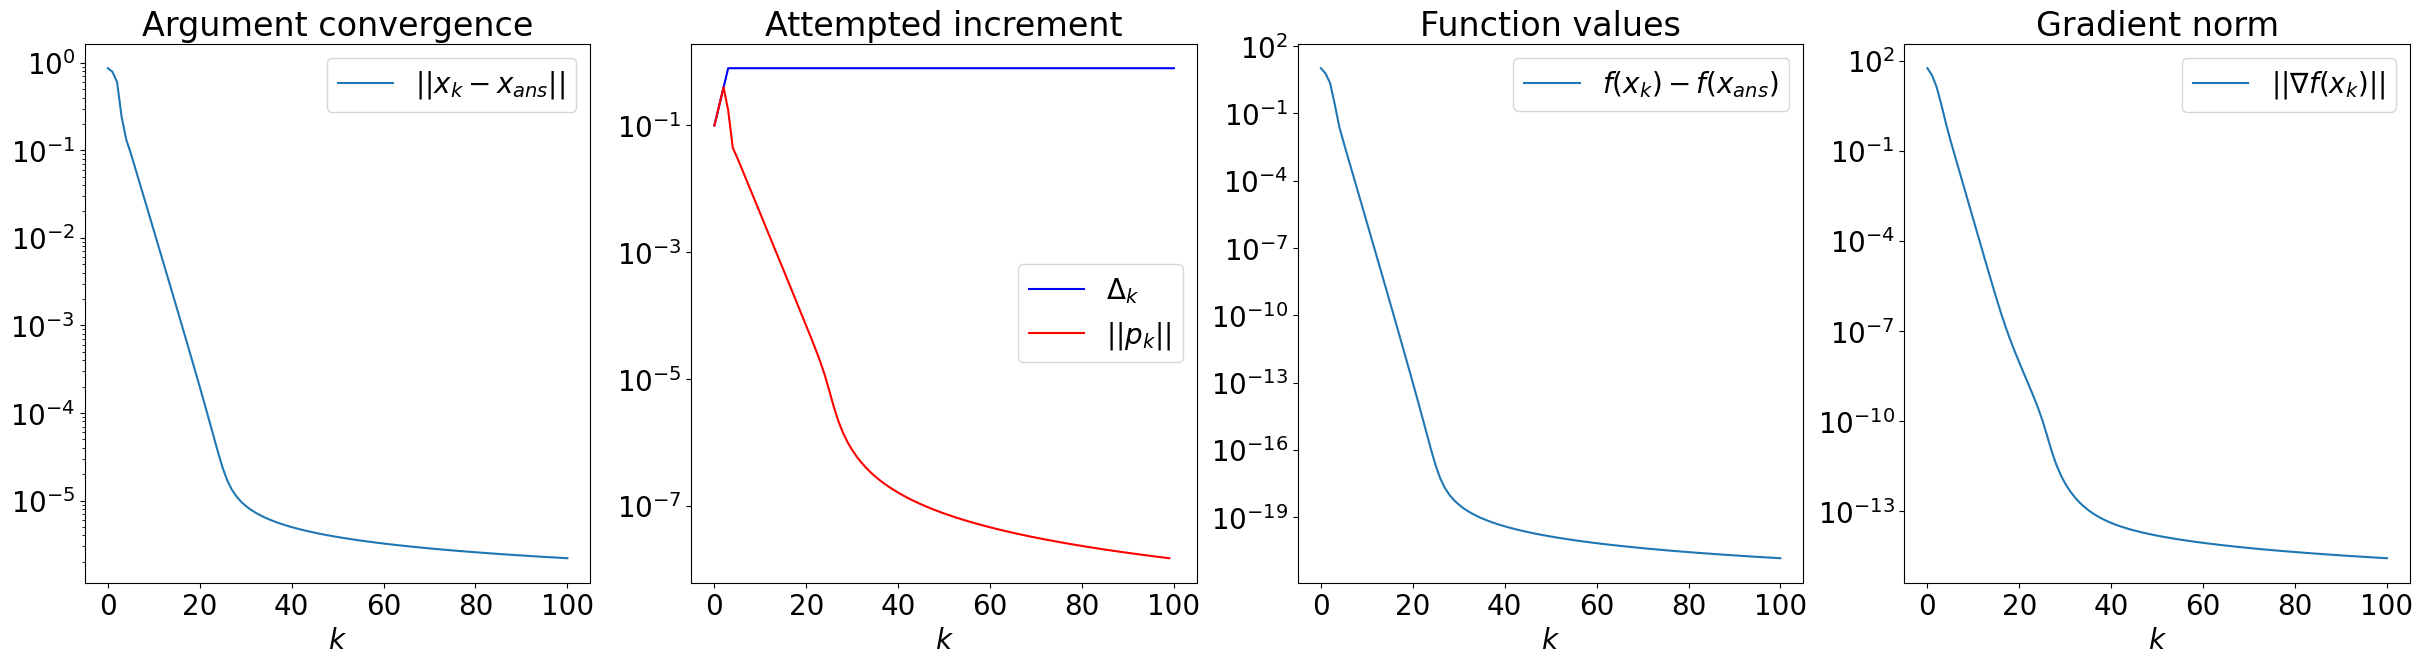

###############################################################################################################################


In [68]:
for c in c_list:
    res = Trust_area_method(f=f, grad_f=grad_f, hessian_f=hessian_f, 
                            x_0=x_0, delta_0=0.1, delta_max=1, eta=1/5, iter_max=100, type="Full",
                            c=c)
    
    print(f"For c={c} achieved value is {f(res[0], c=c)[0, 0]} in the point {res[0].flatten()}")

    plot_graphs(dynamic=res[1], f=f, grad_f=grad_f, x_ans=np.zeros_like(x_0), log_scale=True, one_line=True, c=c)

    print("###############################################################################################################################")

For c=1 achieved value is 3.427217504882609e-05 in the point [ 0.07634394 -0.03839056 -0.00147134]


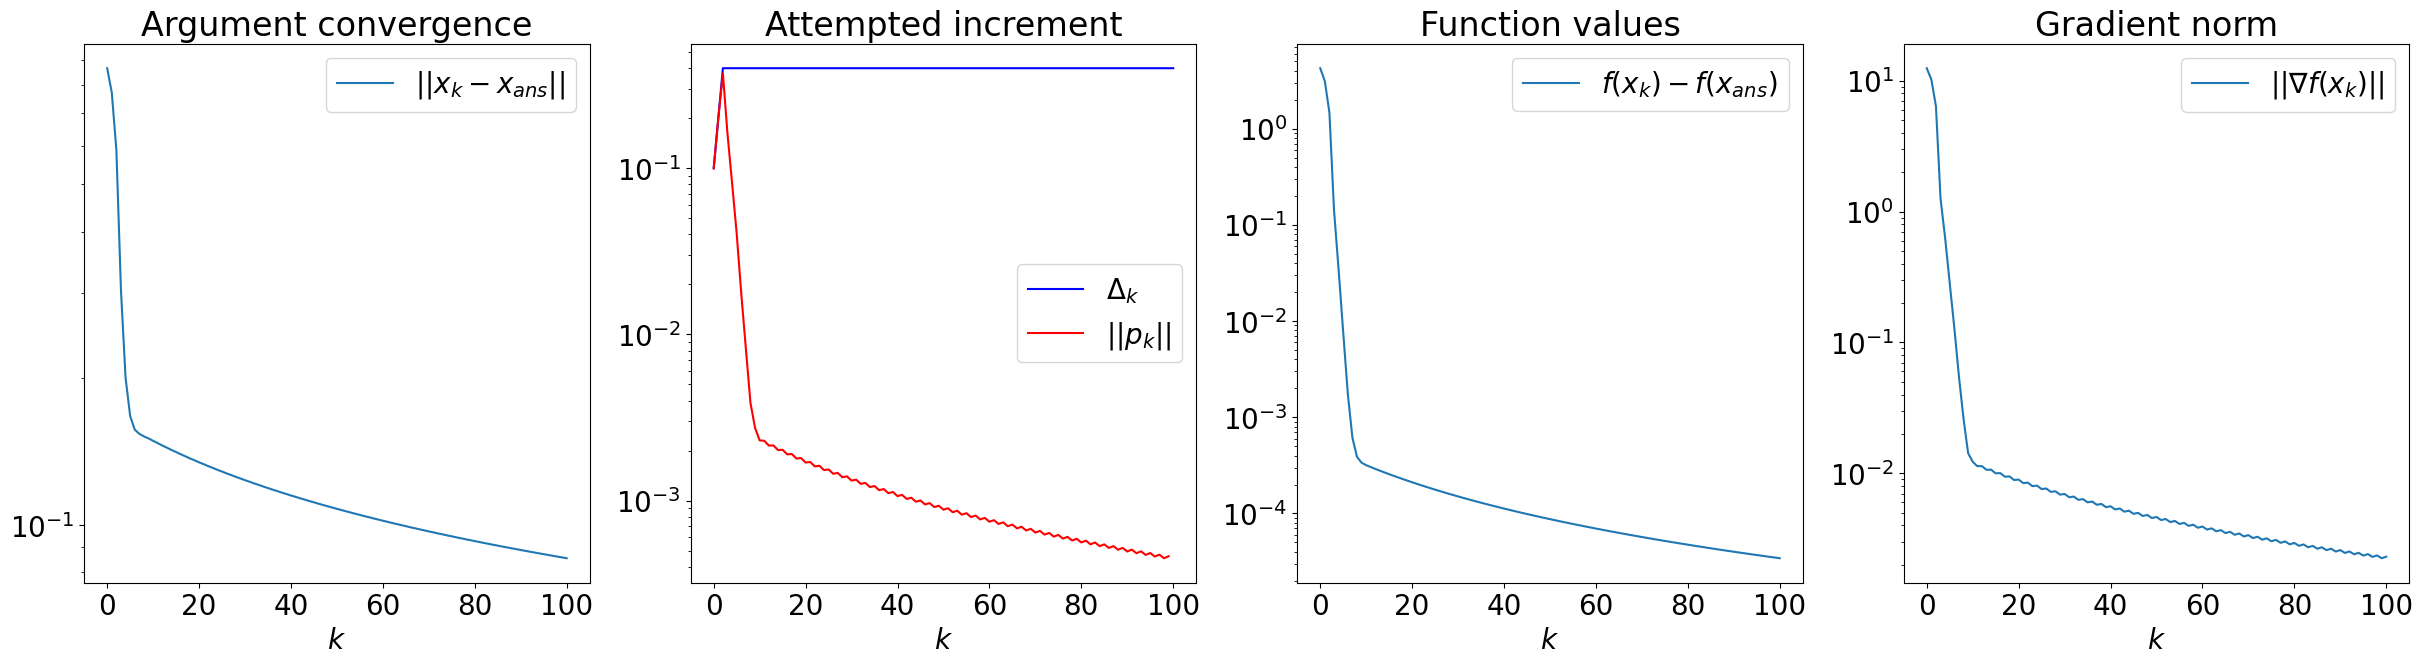

###############################################################################################################################
For c=10 achieved value is 4.069915811954735e-06 in the point [ 0.02521484 -0.01268853 -0.00016098]


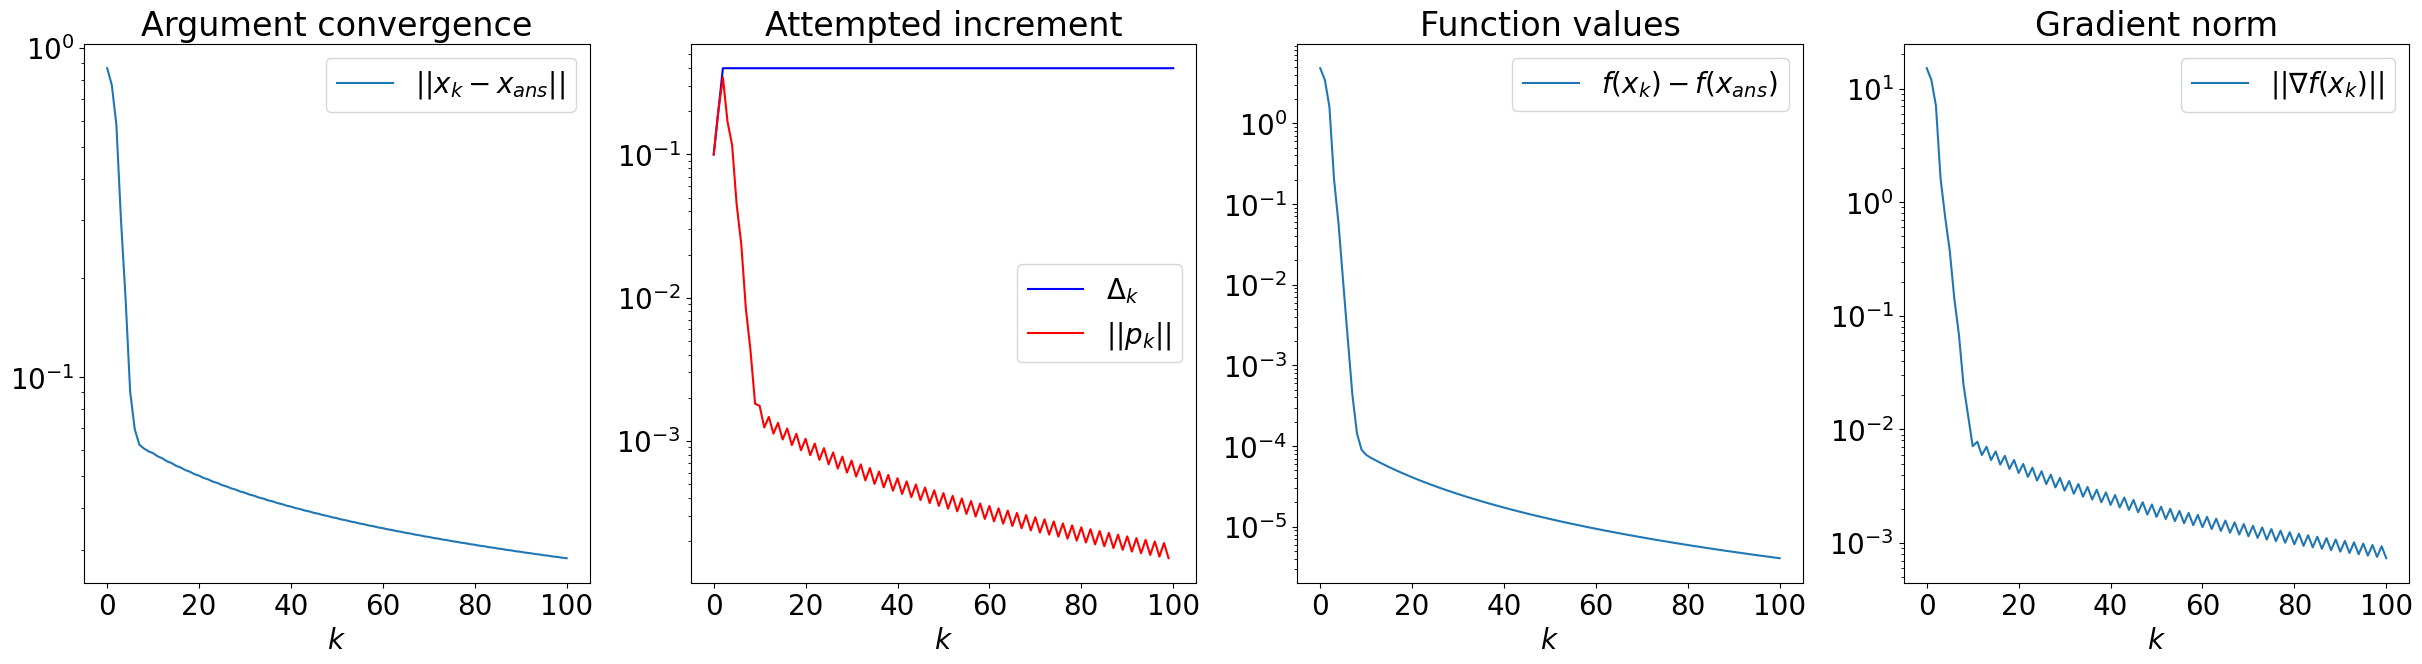

###############################################################################################################################
For c=100 achieved value is 5.745841366562504e-07 in the point [-8.68908201e-03  4.37821024e-03 -1.91683938e-05]


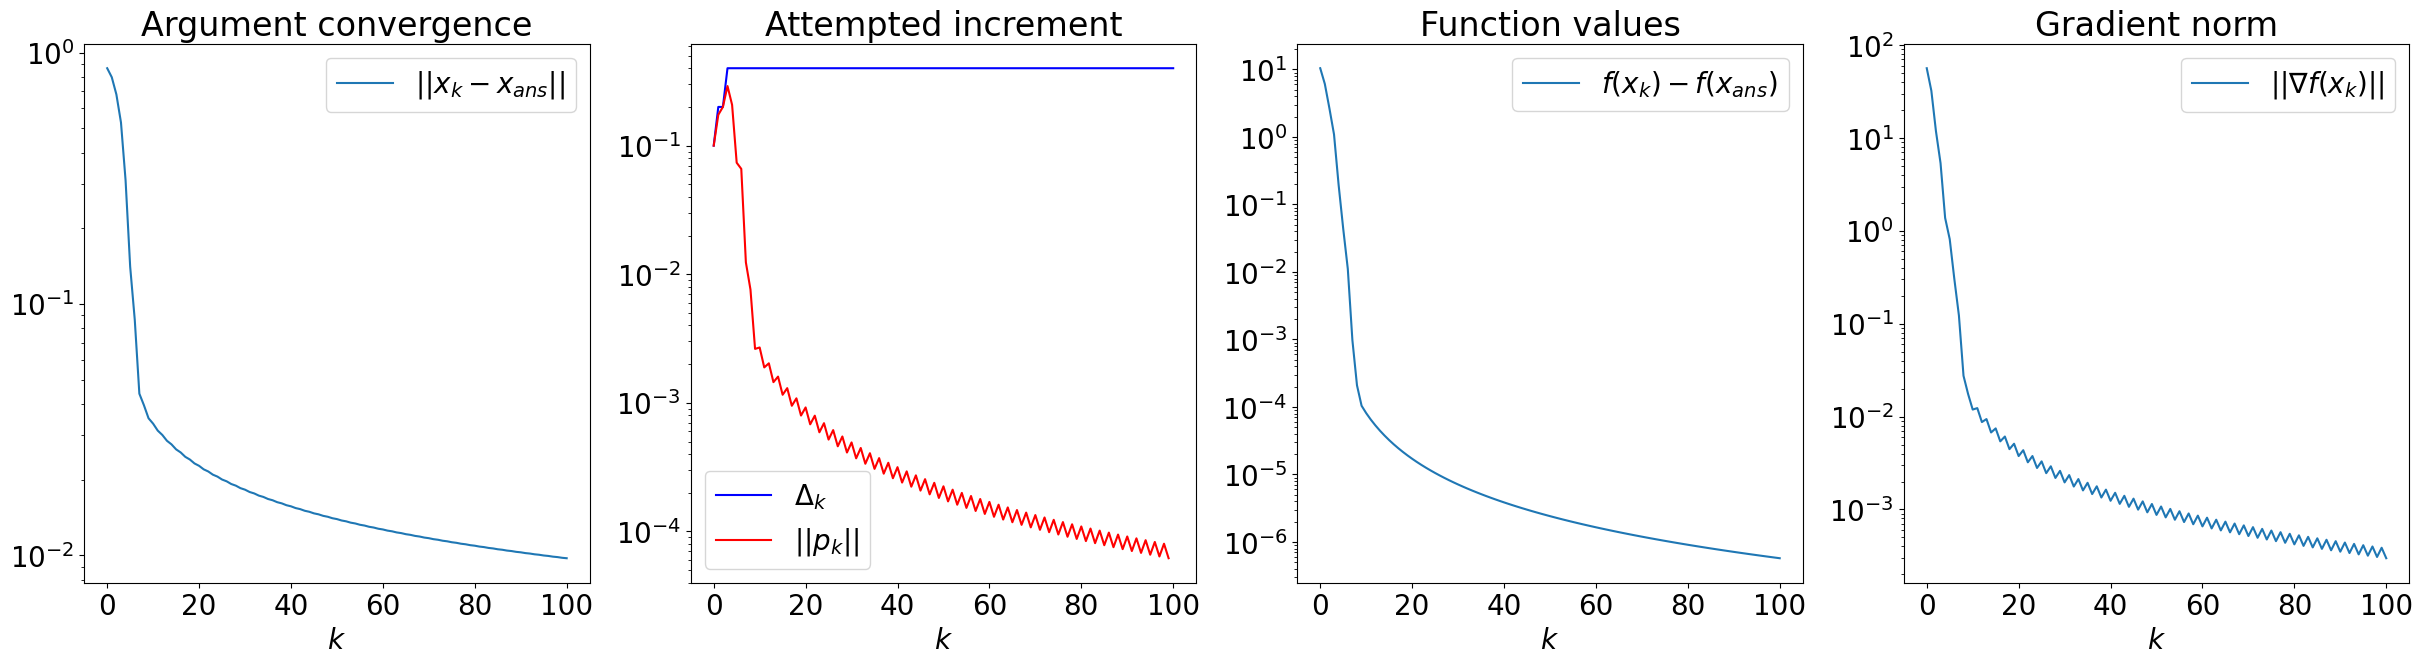

###############################################################################################################################


In [69]:
for c in c_list:
    res = Trust_area_method(f=f, grad_f=grad_f, hessian_f=hessian_f, 
                            x_0=x_0, delta_0=0.1, delta_max=1, eta=1/5, iter_max=100, type="Cauchy",
                            c=c)
    
    print(f"For c={c} achieved value is {f(res[0], c=c)[0, 0]} in the point {res[0].flatten()}")

    plot_graphs(dynamic=res[1], f=f, grad_f=grad_f, x_ans=np.zeros_like(x_0), log_scale=True, one_line=True, c=c)

    print("###############################################################################################################################")

Бачимо, що на $100$ ітераціях метод довірчої області із знаходженням справжньої цільової функції працює на порядки краще по всім вимірам:
1) значення функції (в $\sim 10^{10}$ разів швидше)
2) норма градієнта (в $\sim 10^{11}$ разів швидше)
3) відстань до точки мінімума (в $\sim 10^4$ разів швидше)

Подивимося, чи є виграш в часі:

In [73]:
import time
iter_max = 3000
time_0 = time.time()
res = Trust_area_method(f=f, grad_f=grad_f, hessian_f=hessian_f, 
                        x_0=x_0, delta_0=0.1, delta_max=1, eta=1/5, iter_max=iter_max, type="Full",
                        c=1)
time_1 = time.time()
res = Trust_area_method(f=f, grad_f=grad_f, hessian_f=hessian_f, 
                        x_0=x_0, delta_0=0.1, delta_max=1, eta=1/5, iter_max=iter_max, type="Cauchy",
                        c=1)
time_2 = time.time()

print(f"{iter_max} iterations took {time_1 - time_0:.3f}s for full algorithm and {time_2 - time_1:.3f}s for Cauchy point algorithm on my machine")
print(f"This means that second one is {(time_1 - time_0)/(time_2 - time_1):.3f} times faster")


3000 iterations took 10.219s for full algorithm and 0.320s for Cauchy point algorithm on my machine
This means that second one is 31.982 times faster


Дамо алгоритмам приблизно однакову кількість часу, і порівняємо результати по часу:

Time spent by Full algorithm 1.0245s
Achieved value is 1.0398285506143315e-20 in the point [ 1.00981178e-05 -5.04905892e-06 -2.54929131e-11]


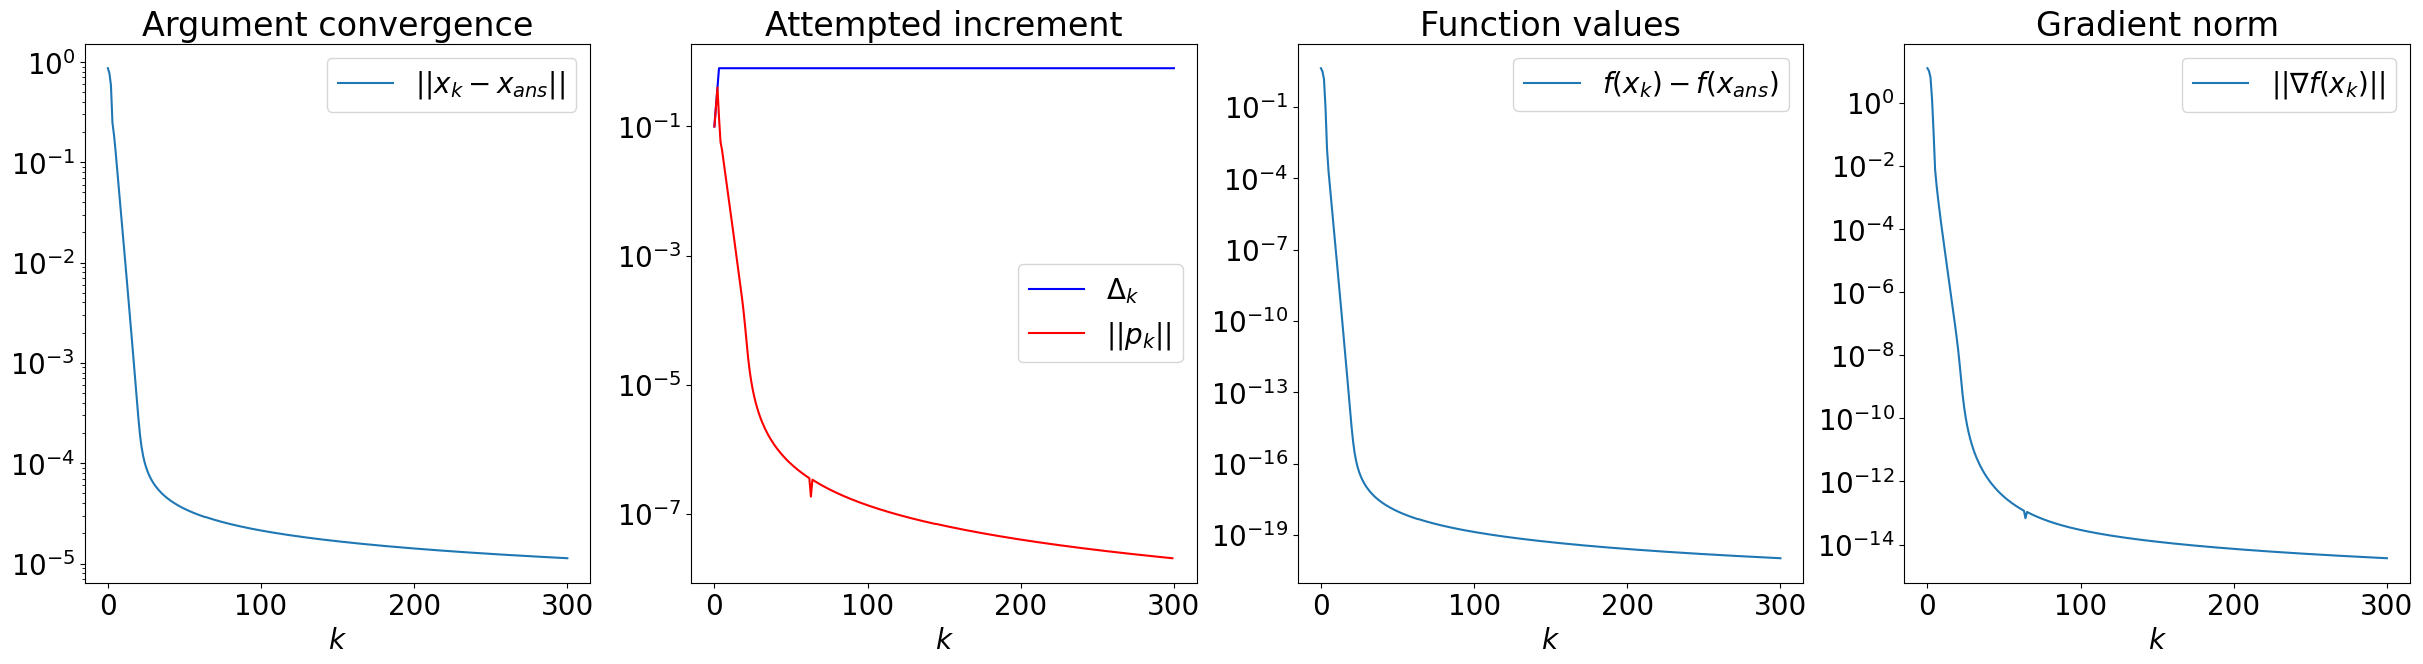

###############################################################################################################################
Time spent by Cauchy point algorithm 1.0029s
Achieved value is 6.566875395033354e-09 in the point [ 9.00173702e-03 -4.50122698e-03 -2.02605350e-05]


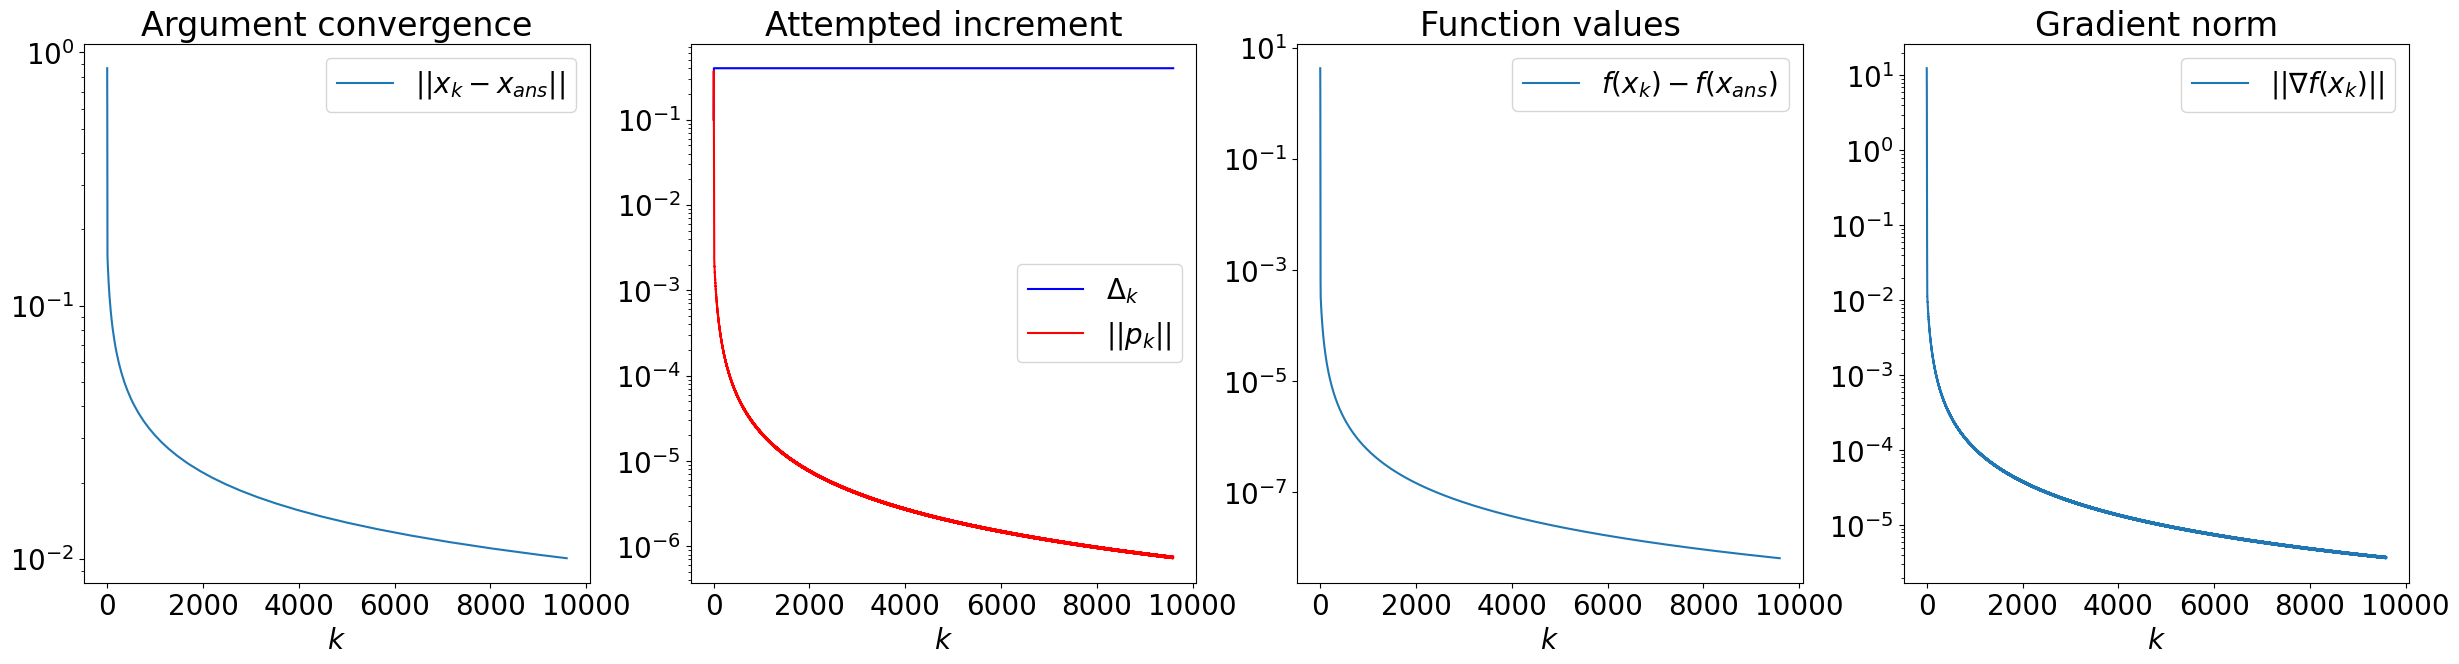

In [78]:
time_advantage = (time_1 - time_0)/(time_2 - time_1)

ti = time.time()
res = Trust_area_method(f=f, grad_f=grad_f, hessian_f=hessian_f, 
                        x_0=x_0, delta_0=0.1, delta_max=1, eta=1/5, iter_max=300, type="Full",
                        c=1)
print(f"Time spent by Full algorithm {time.time()-ti:.4f}s")

print(f"Achieved value is {f(res[0], c=1)[0, 0]} in the point {res[0].flatten()}")

plot_graphs(dynamic=res[1], f=f, grad_f=grad_f, x_ans=np.zeros_like(x_0), log_scale=True, one_line=True, c=1)

print("###############################################################################################################################")

ti = time.time()
res = Trust_area_method(f=f, grad_f=grad_f, hessian_f=hessian_f, 
                        x_0=x_0, delta_0=0.1, delta_max=1, eta=1/5, iter_max=int(300 * time_advantage), type="Cauchy",
                        c=1)
print(f"Time spent by Cauchy point algorithm {time.time()-ti:.4f}s")

print(f"Achieved value is {f(res[0], c=1)[0, 0]} in the point {res[0].flatten()}")

plot_graphs(dynamic=res[1], f=f, grad_f=grad_f, x_ans=np.zeros_like(x_0), log_scale=True, one_line=True, c=1)

Бачимо, що поправка на час виконання програми не дає переваги алгоритму заснованому на точці Коші для цієї задачі. 

#### Func_2 Test

In [83]:
x_0 = np.array([0.0, 0.0]).reshape([-1, 1])

Спробуємо запустити алгоритм для оригінальної функції target:

C:\Users\Asus\AppData\Local\Temp\ipykernel_21196\3944674595.py:2: RuntimeWarning: divide by zero encountered in log
  return - np.sum(Y * np.log(Y_hat) + (1 - Y)*np.log(1 - Y_hat))
C:\Users\Asus\AppData\Local\Temp\ipykernel_21196\3944674595.py:2: RuntimeWarning: invalid value encountered in multiply
  return - np.sum(Y * np.log(Y_hat) + (1 - Y)*np.log(1 - Y_hat))


Achieved value is 2.3151669384847287 in the point [16.84306269  5.61538586]


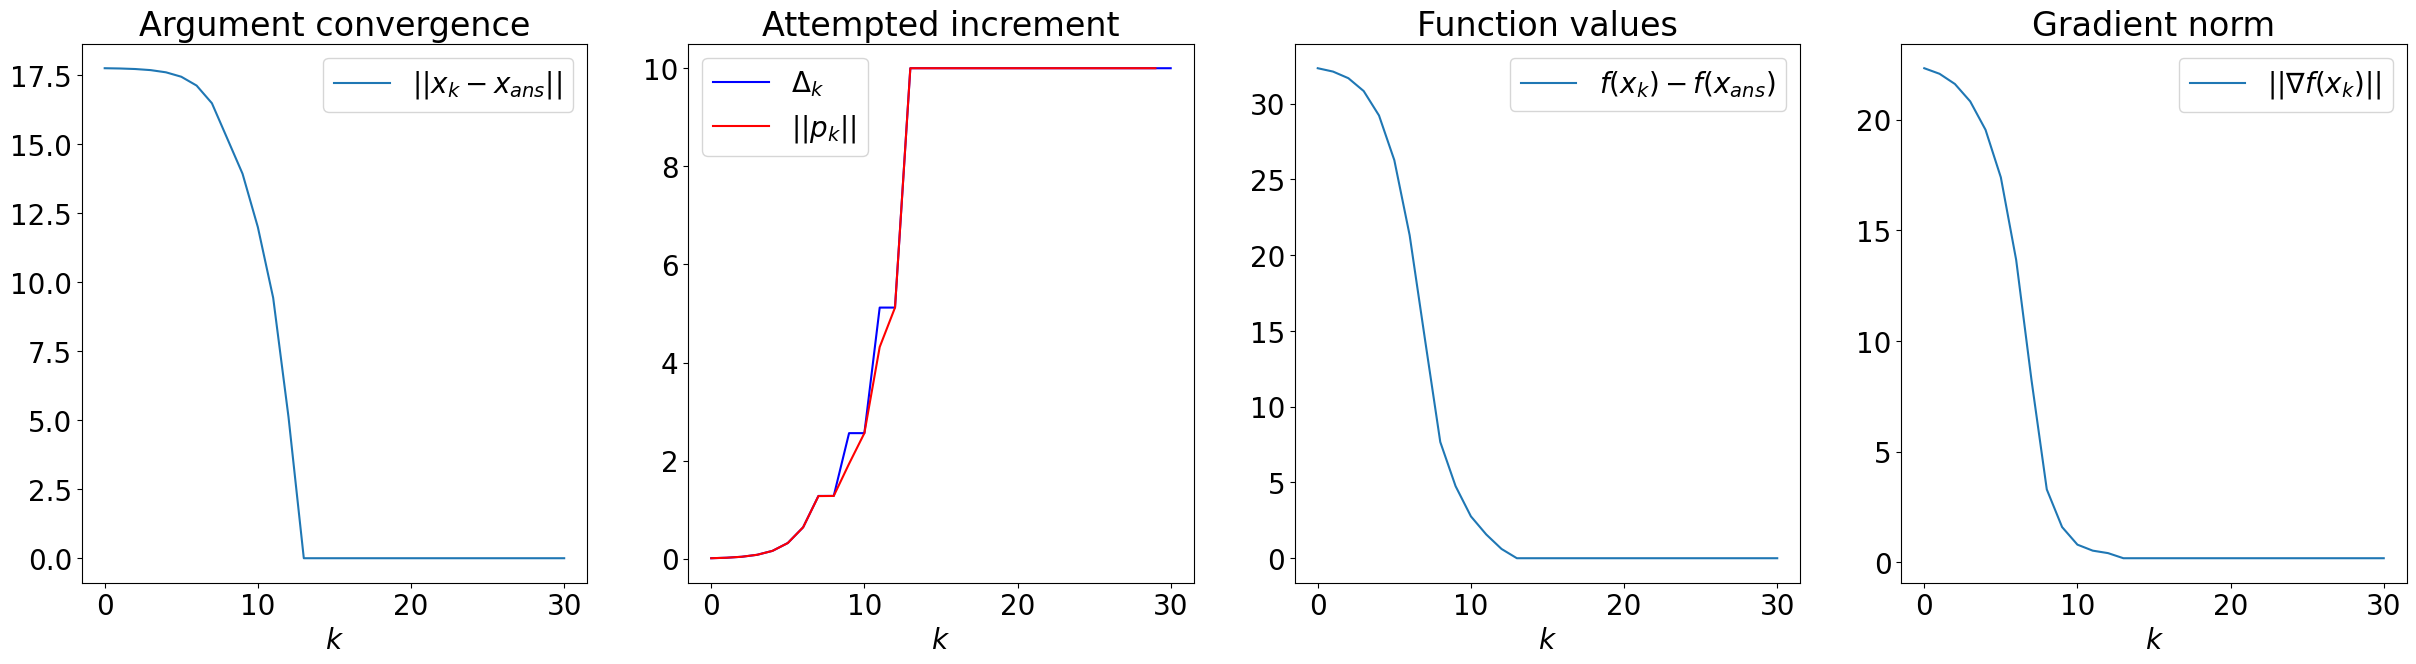

In [88]:
res = Trust_area_method(f=target, grad_f=grad_target, hessian_f=hessian_target, 
                        x_0=x_0, delta_0=0.01, delta_max=10, eta=1/5, iter_max=30, type="Full",
                        X=X, Y=Y)

print(f"Achieved value is {target(res[0], X, Y)} in the point {res[0].flatten()}")

plot_graphs(dynamic=res[1], f=target, grad_f=grad_target, log_scale=False, one_line=True, X=X, Y=Y)

Бачимо, що він ламається приблизно на 12й ітерації через те що намагається рахувати $log(0)$. Після цього значення параметрів не змінюється. Тим не менш, перевіримо результат класифікації:

In [89]:
w1, w2= res[0]

print(f"Ratio if coefficients w1 and w2 is {w1[0]/w2[0]:.3f} which is close to 3/1 = 3, and that should be expected." )

Y_pred = (w1 * X[:, 0] + w2 * X[:, 1] > 0).astype(int)
Y_pred = Y_pred.reshape((-1, 1))

print(f"The number of incorrectly labeled is {np.sum(np.abs(Y - Y_pred))} (out of 50).")

Ratio if coefficients w1 and w2 is 2.999 which is close to 3/1 = 3, and that should be expected.
The number of incorrectly labeled is 1 (out of 50).


Використаємо другий підхід до підрахунку target:

C:\Users\Asus\AppData\Local\Temp\ipykernel_21196\822363747.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  rho = (m.c - f(x + p, **kwargs))/(m.c - min_val)    # m.c = m(0) = f(x) ; min_val = m(p)


Achieved value is 1.2398613476505207 in the point [58.32950835 19.70795052]


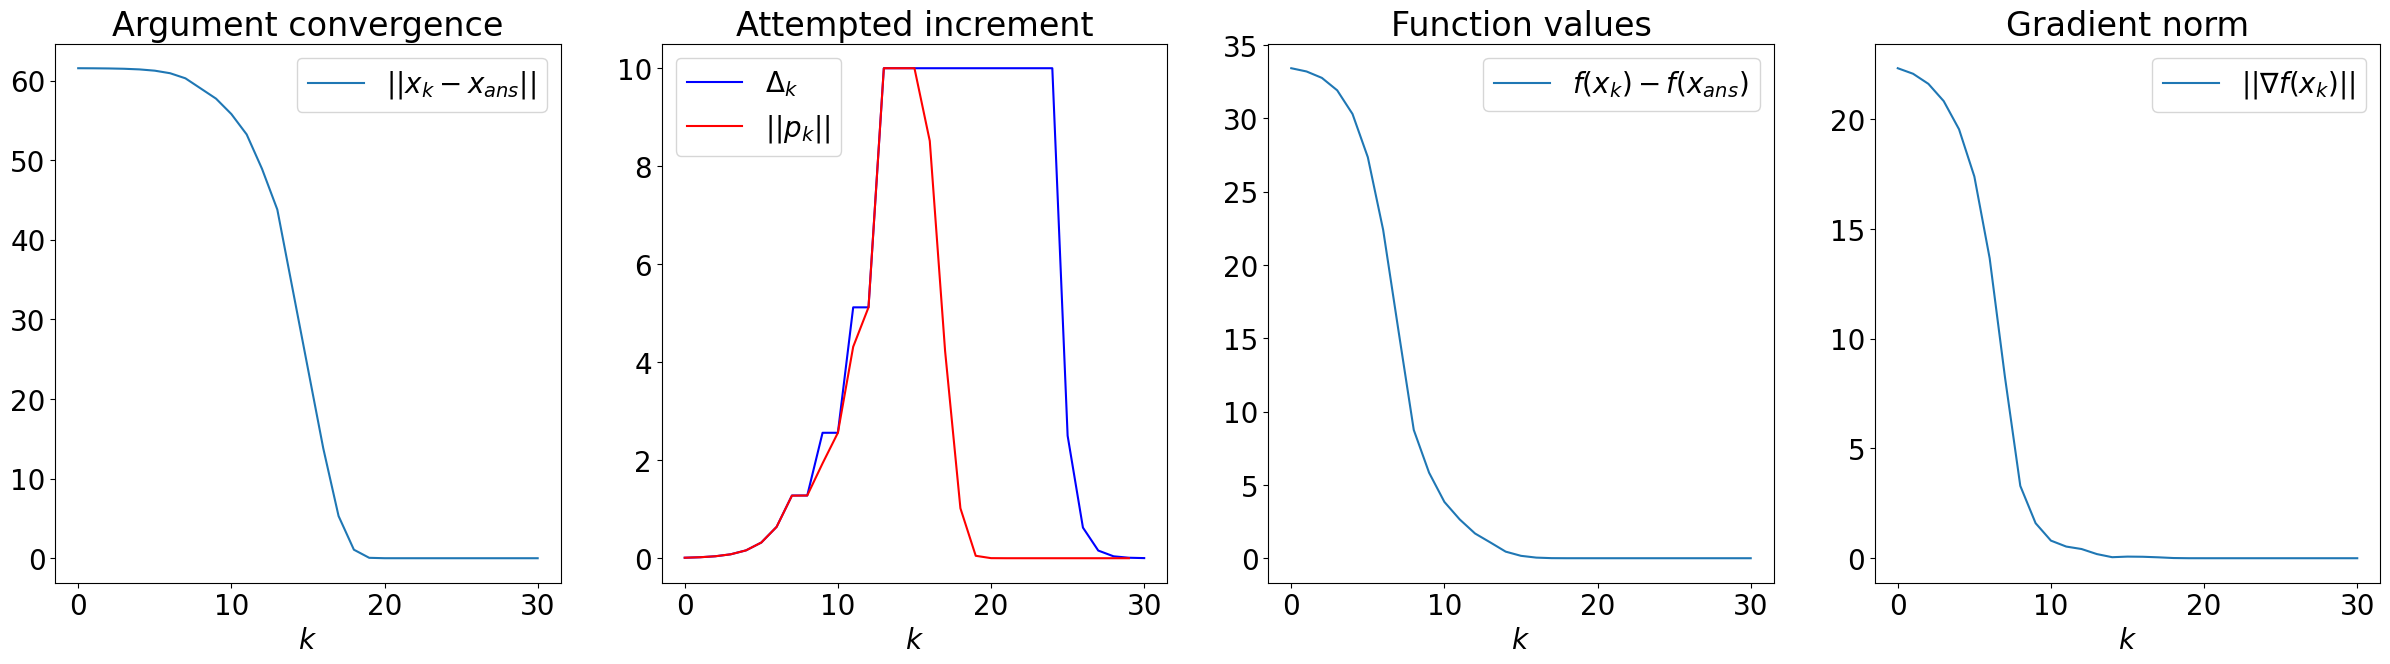

In [90]:
res = Trust_area_method(f=target_better, grad_f=grad_target, hessian_f=hessian_target, 
                        x_0=x_0, delta_0=0.01, delta_max=10, eta=1/5, iter_max=30, type="Full",
                        X=X, Y=Y)

print(f"Achieved value is {target_better(res[0], X, Y)} in the point {res[0].flatten()}")

plot_graphs(dynamic=res[1], f=target_better, grad_f=grad_target, log_scale=False, one_line=True, X=X, Y=Y)

Бачимо, що алгоритм дібрався до меншого значення цільової функції $(1.23 < 2.31)$ та прожив до 19ї ітерації. Алгоритм зламався вже на тому, що отримав $m_k(0) = m_k(p_k)$, із чим вже складно щось зробити. Перевіримо результат класифікації. 

In [91]:
w1, w2= res[0]

print(f"Ratio if coefficients w1 and w2 is {w1[0]/w2[0]:.3f} which is close to 3/1 = 3, and that should be expected." )

Y_pred = (w1 * X[:, 0] + w2 * X[:, 1] > 0).astype(int)
Y_pred = Y_pred.reshape((-1, 1))

print(f"The number of incorrectly labeled is {np.sum(np.abs(Y - Y_pred))}.")

Ratio if coefficients w1 and w2 is 2.960 which is close to 3/1 = 3, and that should be expected.
The number of incorrectly labeled is 1.


Отже, кращого результату з точки зору класифікації не отримали. Скоріш за все його отримати і не можливо в цьому випадку (тут кращий результат це ідеальна класифікація). 

Також на графіках тут та нижче ми припускаємо $x_{ans}$ рівним останньому значенню яке отримав алгоритм. Очевидно воно не є найкращим, але будемо дивитися на динаміку з якою алгоритм підходить до нього.

Тепер подивимося на метод точки Коші:

Achieved value is 2.2699362821792426 in the point [17.30406542  5.80158973]


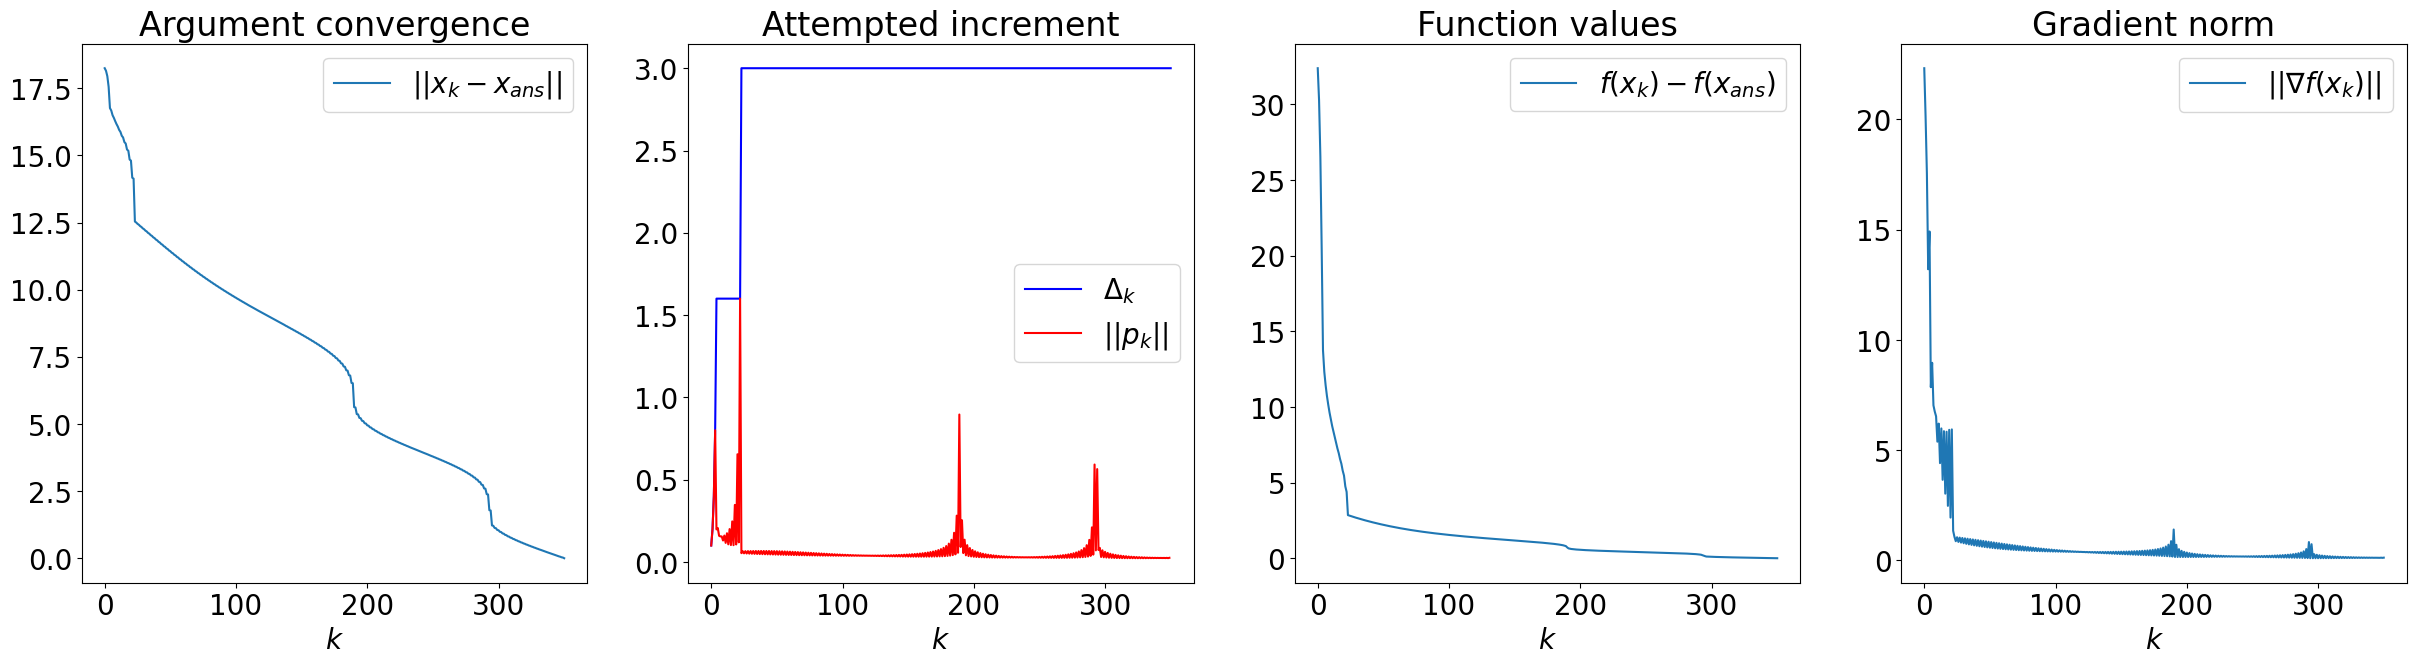

In [97]:
res = Trust_area_method(f=target, grad_f=grad_target, hessian_f=hessian_target, 
                        x_0=x_0, delta_0=0.1, delta_max=3, eta=1/5, iter_max=350, type="Cauchy",
                        X=X, Y=Y)

print(f"Achieved value is {target(res[0], X, Y)} in the point {res[0].flatten()}")

plot_graphs(dynamic=res[1], f=target, grad_f=grad_target, log_scale=False, one_line=True, X=X, Y=Y)

Бачимо дуже повільну швидкість збіжності. За 350 ітерацій отримали значення цільової функції 2.26, яке порівняне із запуском на 11 ітерацій, і гірше ніж записк на 19 ітерацій. Якщо поставити більше ітерацій, то виникне та сама помилка, що і до того із чистою функцією target. Перевіримо результат класифікації:

In [98]:
w1, w2= res[0]

print(f"Ratio if coefficients w1 and w2 is {w1[0]/w2[0]:.3f} which is close to 3/1 = 3, and that should be expected." )

Y_pred = (w1 * X[:, 0] + w2 * X[:, 1] > 0).astype(int)
Y_pred = Y_pred.reshape((-1, 1))

print(f"The number of incorrectly labeled is {np.sum(np.abs(Y - Y_pred))}.")

Ratio if coefficients w1 and w2 is 2.983 which is close to 3/1 = 3, and that should be expected.
The number of incorrectly labeled is 1.


Бачимо, що всі алгоритми дають один міскласифікований результат. Наостанок, подивимося як себе буде поводити алгоритм точки Коші із використанням покращеною функції target. Будемо дивитися на цю динаміку при різній кількості ітерацій (бо тут цікаві картинки)

Achieved value (100 iterations) is 3.8098839535152 in the point [8.13129983 2.64302589]


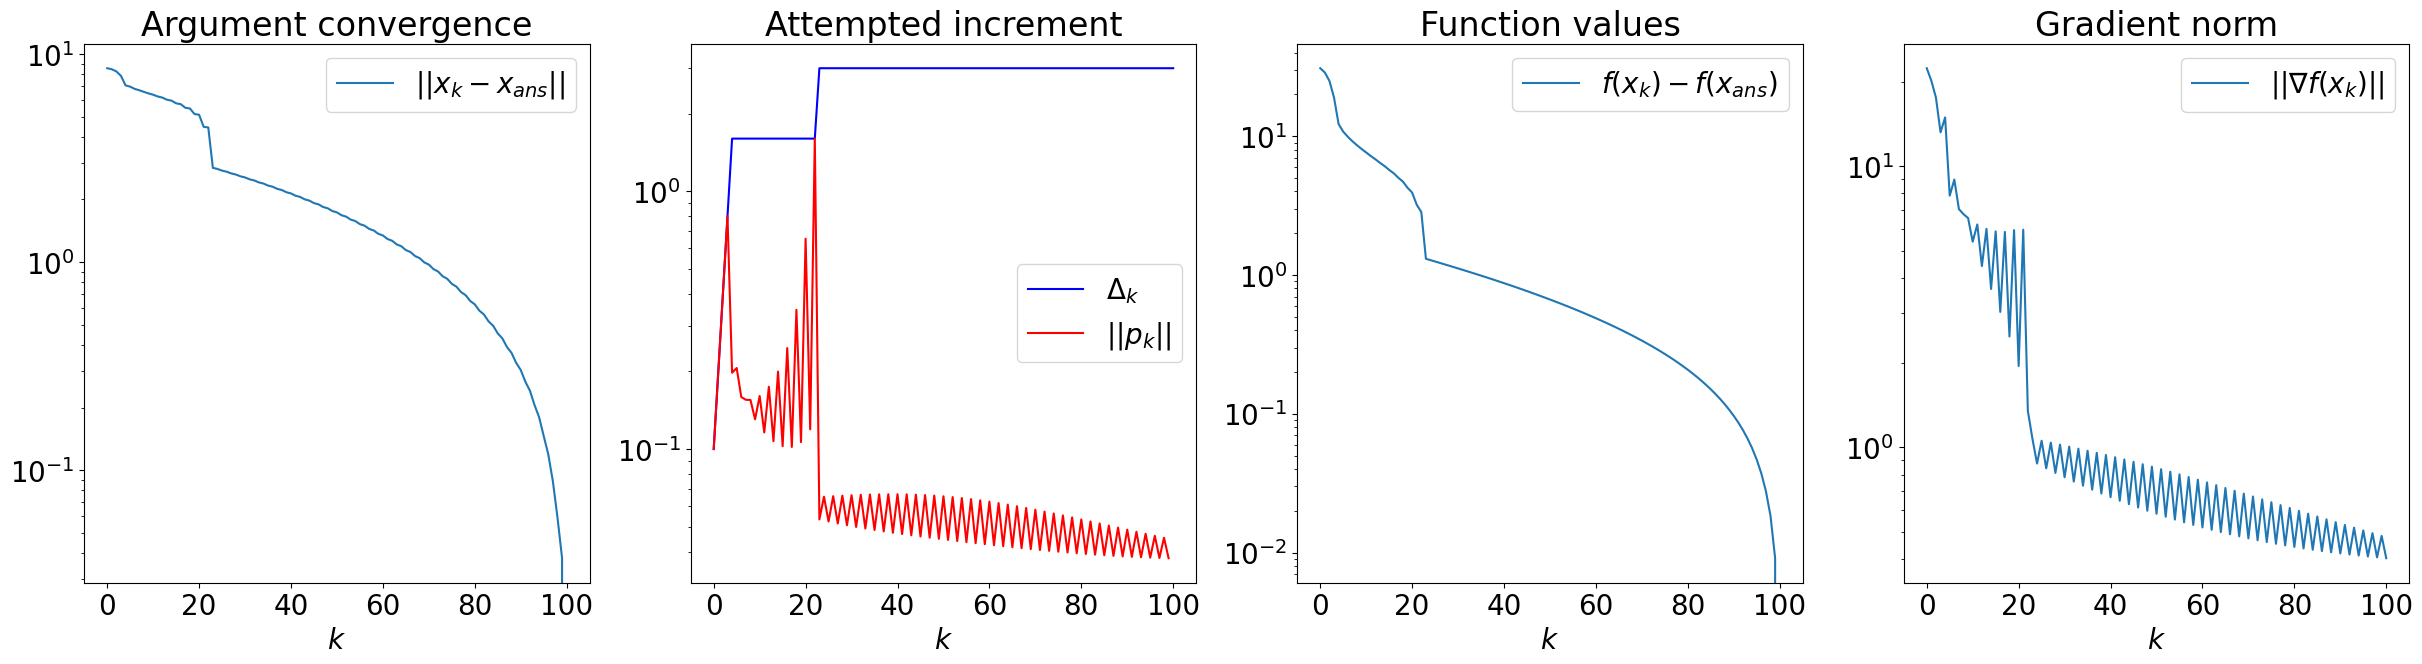

In [105]:
res = Trust_area_method(f=target_better, grad_f=grad_target, hessian_f=hessian_target, 
                        x_0=x_0, delta_0=0.1, delta_max=3, eta=1/5, iter_max=100, type="Cauchy",
                        X=X, Y=Y)

print(f"Achieved value (100 iterations) is {target_better(res[0], X, Y)} in the point {res[0].flatten()}")

plot_graphs(dynamic=res[1], f=target_better, grad_f=grad_target, log_scale=True, one_line=True, X=X, Y=Y)

Achieved value (500 iterations) is 1.924442711490405 in the point [21.82483502  7.35003986]


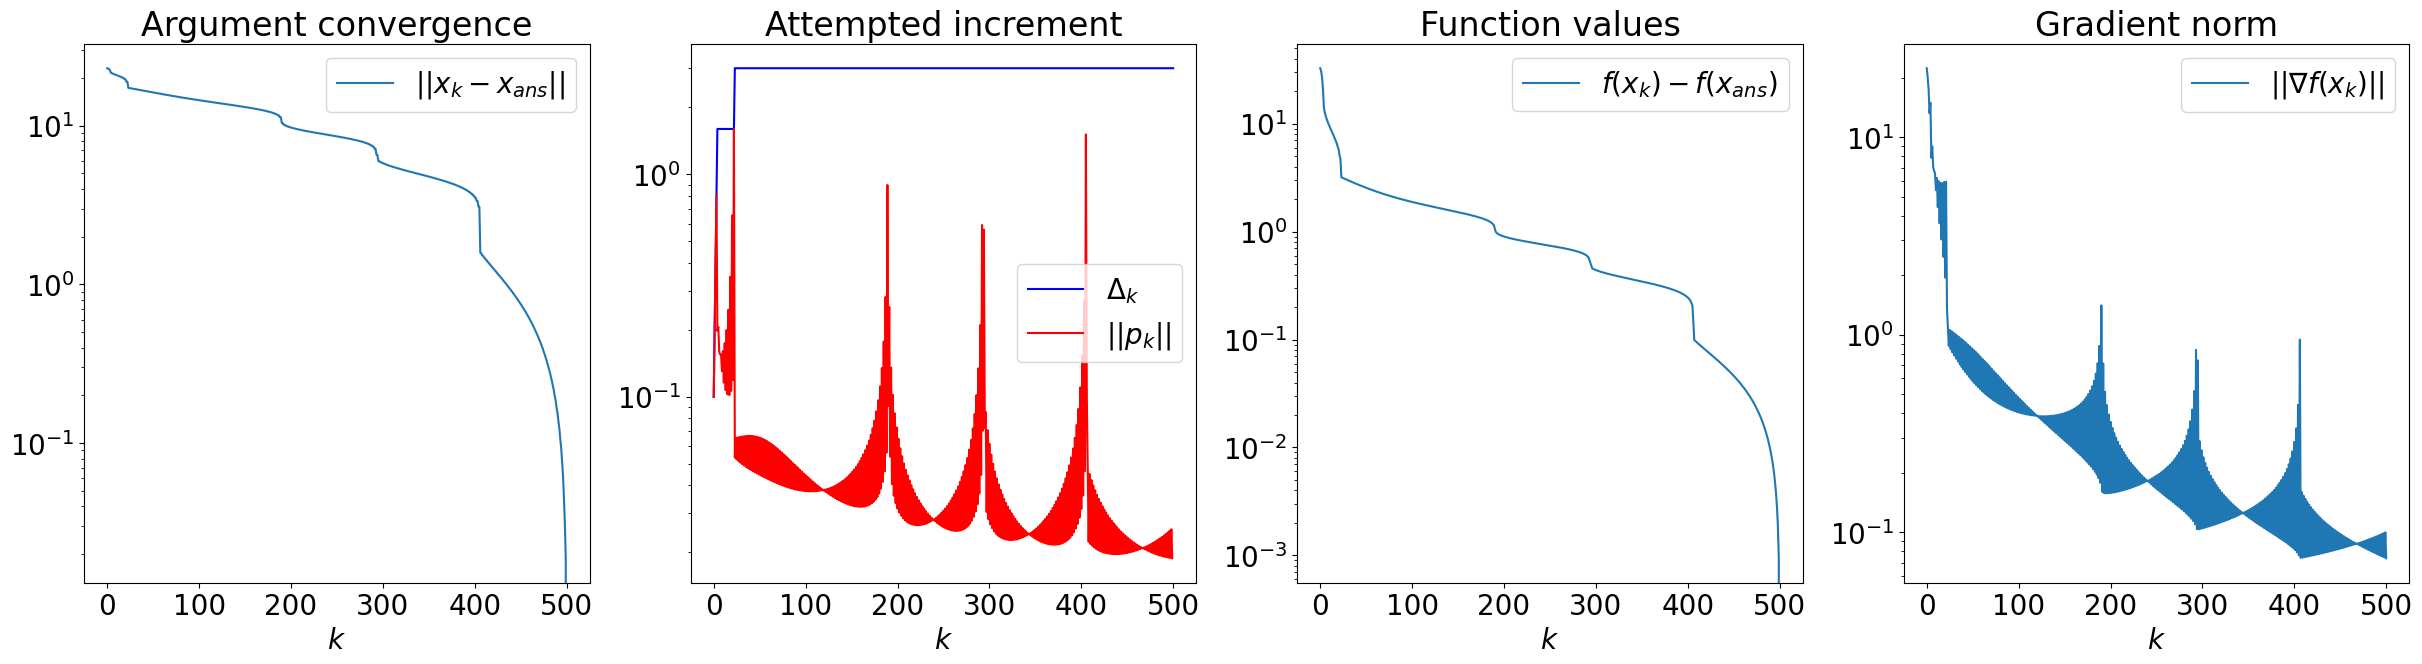

In [108]:
res = Trust_area_method(f=target_better, grad_f=grad_target, hessian_f=hessian_target, 
                        x_0=x_0, delta_0=0.1, delta_max=3, eta=1/5, iter_max=500, type="Cauchy",
                        X=X, Y=Y)

print(f"Achieved value (500 iterations) is {target_better(res[0], X, Y)} in the point {res[0].flatten()}")

plot_graphs(dynamic=res[1], f=target_better, grad_f=grad_target, log_scale=True, one_line=True, X=X, Y=Y)

Achieved value (1000 iterations) is 1.5033660657457697 in the point [31.51674508 10.69085936]


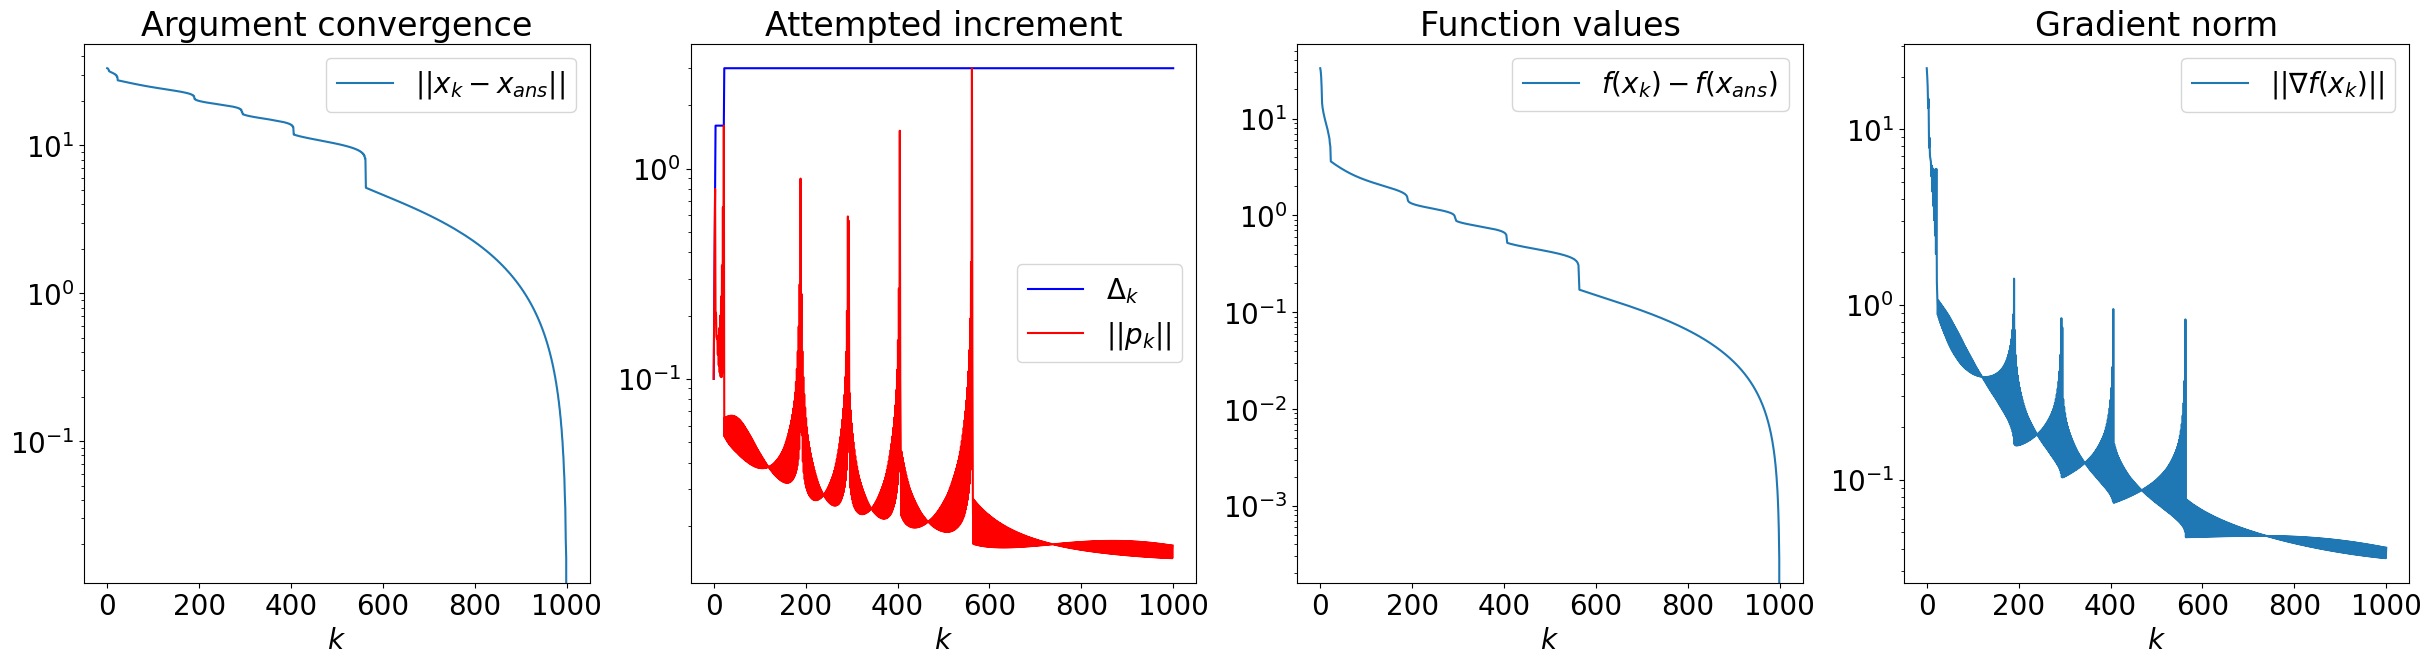

In [109]:
res = Trust_area_method(f=target_better, grad_f=grad_target, hessian_f=hessian_target, 
                        x_0=x_0, delta_0=0.1, delta_max=3, eta=1/5, iter_max=1000, type="Cauchy",
                        X=X, Y=Y)

print(f"Achieved value (1000 iterations) is {target_better(res[0], X, Y)} in the point {res[0].flatten()}")

plot_graphs(dynamic=res[1], f=target_better, grad_f=grad_target, log_scale=True, one_line=True, X=X, Y=Y)

Achieved value (10000 iterations) is 1.239861392684168 in the point [58.31293132 19.70245971]


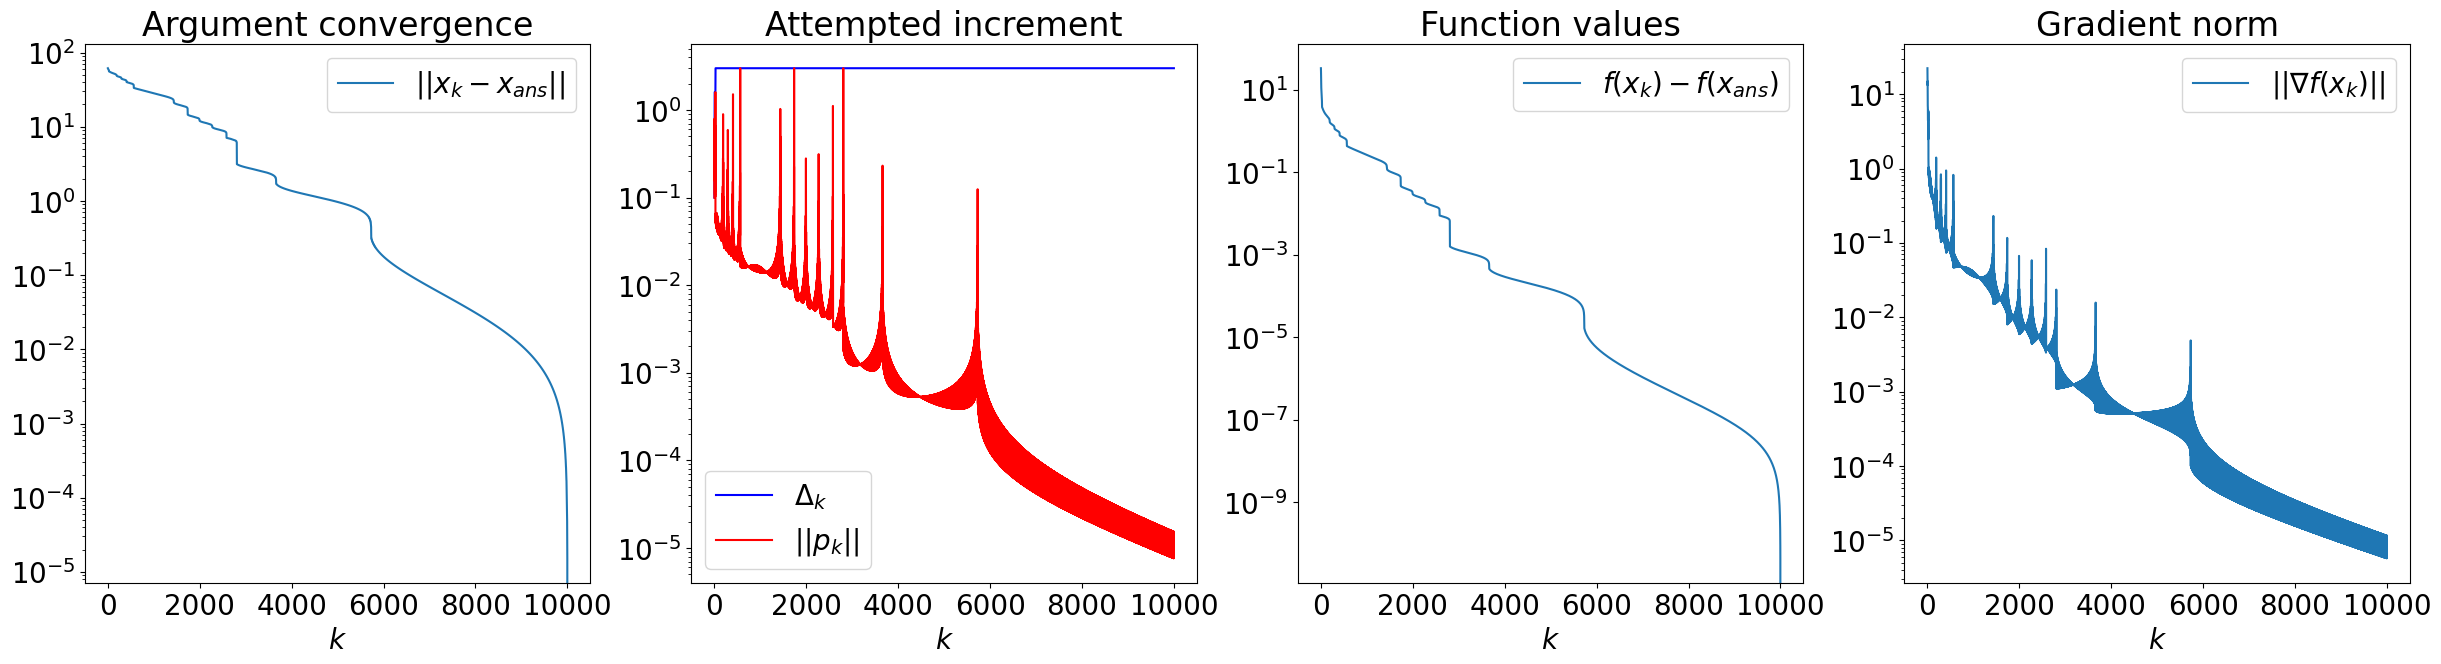

In [110]:
res = Trust_area_method(f=target_better, grad_f=grad_target, hessian_f=hessian_target, 
                        x_0=x_0, delta_0=0.1, delta_max=3, eta=1/5, iter_max=10000, type="Cauchy",
                        X=X, Y=Y)

print(f"Achieved value (10000 iterations) is {target_better(res[0], X, Y)} in the point {res[0].flatten()}")

plot_graphs(dynamic=res[1], f=target_better, grad_f=grad_target, log_scale=True, one_line=True, X=X, Y=Y)

Achieved value (10000 iterations) is 1.239861347660318 in the point [58.32926381 19.70786952]


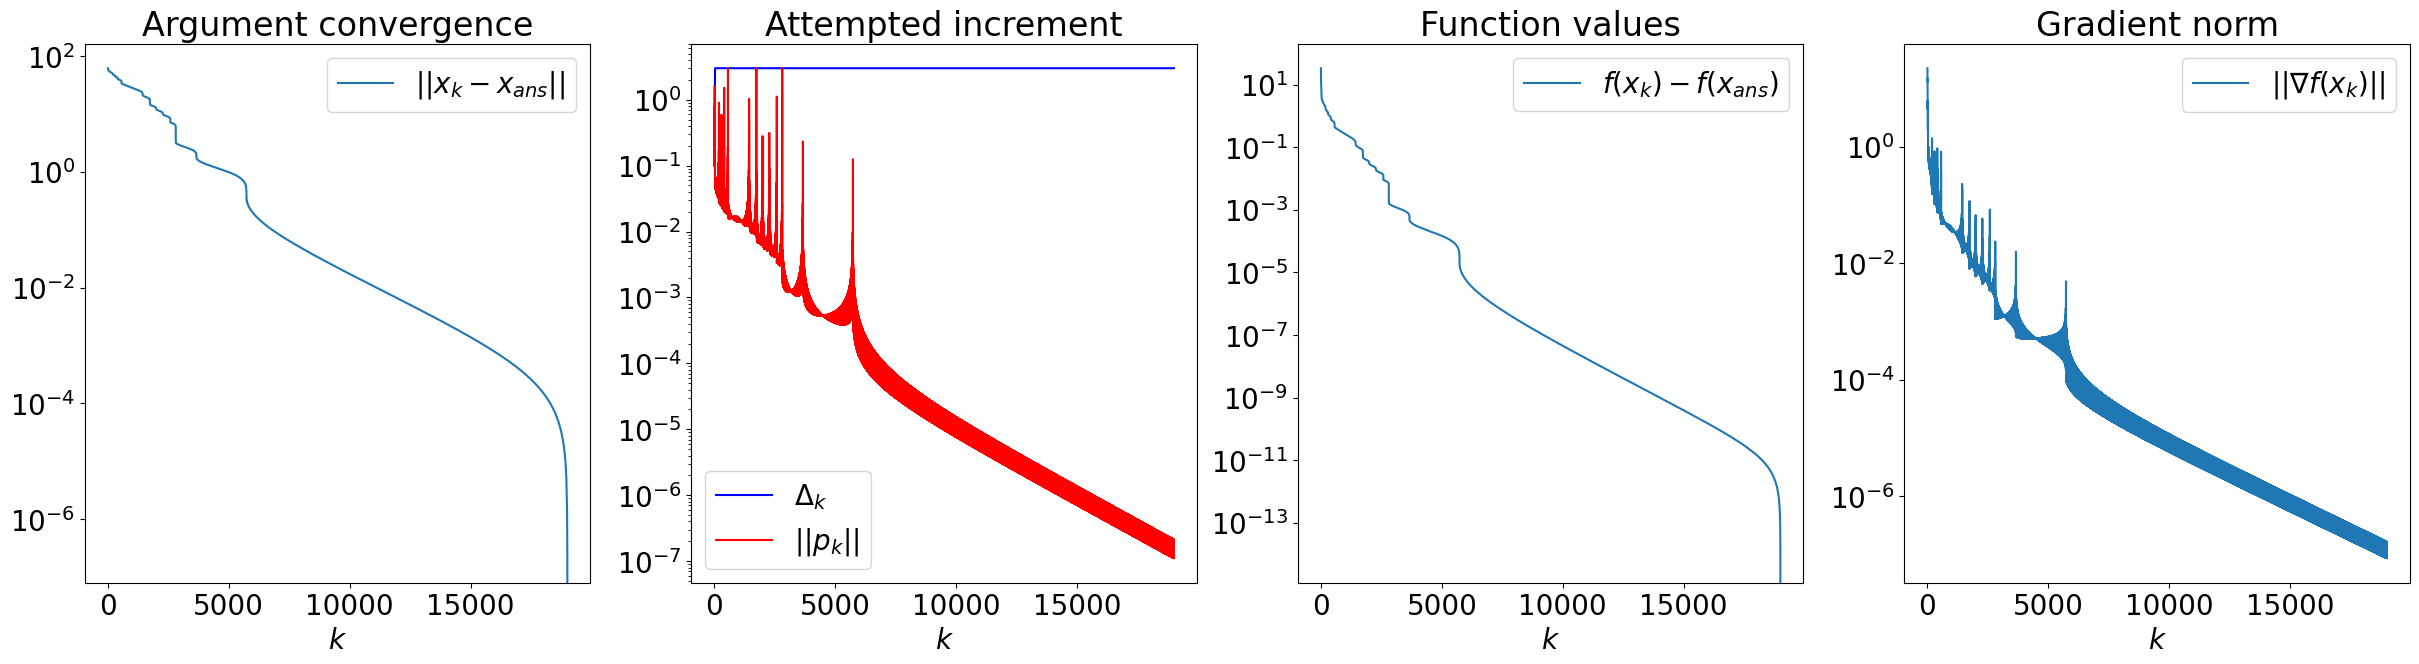

In [112]:
res = Trust_area_method(f=target_better, grad_f=grad_target, hessian_f=hessian_target, 
                        x_0=x_0, delta_0=0.1, delta_max=3, eta=1/5, iter_max=19000, type="Cauchy",
                        X=X, Y=Y)

print(f"Achieved value (10000 iterations) is {target_better(res[0], X, Y)} in the point {res[0].flatten()}")

plot_graphs(dynamic=res[1], f=target_better, grad_f=grad_target, log_scale=True, one_line=True, X=X, Y=Y)

Найцікавіше в цій ситуації те, що ми отримали остаточне значення функції рівне 1.23986, що відповідає мінімальному значенню отриманому підходом оптимізації за 19 кроків повним алгоритмом. Більше того, значення $w_1, w_2$ виявились приблизно однаковими в цих двох випадках.

In [113]:
w1, w2= res[0]

print(f"Ratio if coefficients w1 and w2 is {w1[0]/w2[0]:.3f} which is close to 3/1 = 3, and that should be expected." )

Y_pred = (w1 * X[:, 0] + w2 * X[:, 1] > 0).astype(int)
Y_pred = Y_pred.reshape((-1, 1))

print(f"The number of incorrectly labeled is {np.sum(np.abs(Y - Y_pred))}.")

Ratio if coefficients w1 and w2 is 2.960 which is close to 3/1 = 3, and that should be expected.
The number of incorrectly labeled is 1.


### Висновок

Отже, в роботі реалізований метод довірчої області в двох версіях: із повною мінімізацією допоміжної функції, та із використанням точки Коші. Робота цих методів протестована на потрібних функціях, і порівняні швидкості збіжності цих алгоритмів. 

Отримали надзвичайно велику швидкість збіжності повного алгоритму довірчої області на наших тестових функціях. Також отримали, що використання алгоритму заснованого на точці Коші не дало на цих функціях жодного виграшу ні в результатах оптимізації, ні в часі на отримання цих результатів. Тим не менш у випадку логістичної регресії міскласифікованим виходить лише одна точка у всіх варіантах, на що кожному із алгоритмів потрібно мінімально часу.

Також отримали цікаві патерни поведінки алгоритмів, особливо у випадку точки Коші, особливо у випадку логістичної регресії. Графік поведінки норми градієнту та attempted increment має дуже пилоподібну форму (стосується як першої так і другої цільової функції), а на другій цільовій функції має зовсім спечицічну поведінку. Загальна зашумленість коли значення аргументу +- стабілізуються може бути пояснена тим, що мабуть чим менше стає значення норми градієнта, тим гірше працює підхід точки Коші, і тим гірше він наближає справжній минімум допоміжної функції, що спричинає таку "невпевнену" поведінку. Натомість глобальний дивний патерн на мою думку може бути викликаний місцями переходу прямої $w_1x_1 + w_2x_2 = 0$ через точки вибірки $X$. Тоді збільшена "хаотичність" та піки на графіку attempted increment можуть бути пов'язані із відстаню від цієї прямої до точок вибірки. Думаю в ці ж моменти відбувається краш алгоритму. Тим не менш, це лише гіпотеза.